# В поисках лучших клиентов

Ключевой актив любой компании - это ее клиенты. Они могут как приносить прибыль и формировать устойчивое будущее компании, так и наносить финансовый ущерб. И это наиболее важная область деятельности компании, где теребуется наладить анализ, учет и контроль. Вплоть до того, чтобы ввести новый функицонал: бухгалтер по клиентам. Ведь за потерю клиента, в отличии от других материальных аткивов компании никто не отвечает.

С другой стороны, предложенная схема анализа клиентской базы это первый шаг к использованию машинного обучения в продажах и маркетинге. А это:
* понимания рисков и приоритетов по каждому из клиентов. Результаты анализа часто переворачивают базовые представления о клиентах. 
* сегметация клиентов на основе поведенческих факторов (покупок).
* автоматизация рекомедаций по дополнительным товарам и услугам, поиск возможностей для допродаж клиентам.
* предсказание периода будущей покупки и структуры покупки (товары, бренды).
* предсказание риска ухода клиента.
* поиск новых клиентов исходя их профиля их прибыльности/привлекательности для компании. В сети свободно опубликованы базы, например, ФНС, которые можно использовать для обогащения и подбора новых клиентов.
* автоматическое профилирование (оценка привлекательности) клиентов на входе.
* динамическое/динамическое персональное ценообразование.
* персонализация маркетинга и многое другое. 

Ниже представлен полноценный, комплексный алгоритм анализа клиентской базы с кодом и пояснениями. В качестве имен клиентов используются случаной выбранные русские имена. Сам датасет, на котором проводился анализ не будет предоставлен. Но будет описана структура файла с данными. Вы можете или самостоятельно провести анализ или обратиться ко мне за содействием. 

# Изучаем данные на предмет выбросов

Загрузим базовые библиотеки и изучим данные на предмет выбросов. Любые данные чаще всего содержат искажения, ошибки, нестандартные события и тд, которые нуждаются в корректировке и очистке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#загружаем файл с данными
df=pd.read_excel('Q_sample_data.xlsx', sheet_name='Data')
df.head()

,Name,Segment,Invoice,Date,Level1,Level2,Level3,Level4,SKU,Qnty,Revenue,Cost
0,ярослава,Ho-Re-Ka,Фр00-017166,2016-10-28,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",200.00,"276,000.00","160,164.12"
1,емилий,Ho-Re-Ka,Фр00-015446,2016-11-14,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",100.00,"138,000.00","80,000.00"
2,ярослава,Ho-Re-Ka,Фр00-013330,2016-09-30,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",77.00,"110,033.00","63,140.00"
3,ярослава,Ho-Re-Ka,Фр00-013196,2016-09-30,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",75.00,"107,175.00","61,500.00"
4,емилий,Ho-Re-Ka,00UT-002406,2017-06-03,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",34.40,"49,151.88","27,516.80"


Исходно у нас не самый оптимальный по использованию памяти файл, но с ним достаточно удобно работать. Чаще всего, на входе три таблицы:
* данные о транзакциях
* справочник клиентов
* справочник товаров. 

В данном случае эти справочники объединены в один файл. Те каждая строчка - это отдельное наименование, котрое было поставлено клиенту. Ниже расшифровка значений полей.
* 'Name' название клиента (для кодирования использовались русские имена, выбранные случайным образом).
* 'Segment' сегмент, к котрому принадлежит клиент. Это внутрення историческая сегментация компании.
* 'Invoice' номер документа, по которому была осуществлена отрузка. 
* 'Date' дата продажи.
* 'Level1', 'Level2', 'Level3', 'Level4' уровень справочника товаров, к которому принадлежит позиция.
* 'SKU' наименование товара.
* 'Qnty' количество единиц продукта.
* 'Revenue' стоимость продукта.
* 'Cost' себестоимость продукта.

Для анализа нам потребуются дополнительно рассчитанные поля. В частности, занчение дохода от продажи данного товара.

In [3]:
# добавим поле с прибылью от продажи
df['Profit']=df['Revenue']-df['Cost']

In [4]:
df['Date'].describe()

count                  242943
unique                    399
top       2016-07-27 00:00:00
freq                     1311
first     2015-01-10 00:00:00
last      2017-12-01 00:00:00
Name: Date, dtype: object

Итого у нас есть данные за три года. Сейчас в наборе данных 242943 строки начина с 1 января 2015 года до 1 декабря 2017 года. Посмотрим на основные статистики.

In [5]:
df.describe()

,Qnty,Revenue,Cost,Profit
count,"242,922.00","242,927.00","242,943.00","242,927.00"
mean,7.91,626.56,391.97,234.58
std,34.93,"2,041.35","1,285.61",806.93
min,0.07,-86.04,0.02,"-28,043.90"
25%,2.00,140.00,87.50,52.50
50%,5.00,258.00,159.30,92.07
75%,10.00,555.00,370.00,201.38
max,"9,000.00","276,000.00","160,164.12","115,835.88"


В строке count указано количество значимых строк для каждого столбца. Мы видим, что в поле количество есть пропуски, что приводит к пропуска в столбцах с выручкой. В данном случае, у нас нет возможности разобраться в причинах пропусков и мы просто удалим это относительно небольшое количество строк. 

In [6]:
# удалим, чтобы не было ошибок, но стоит разобраться
df.dropna(subset=['Qnty'], axis=0, inplace=True)

Обращает внимание статистика по столбцу Qnty. Так, 75% строк содержат меньше 10 единиц. Но есть строка с количеством единиц товара в 9 0000 единиц. Давайте посмотрим на них подробнее. Отфильтруем все строки с количеством более 2000 единиц товара. 

In [7]:
df[df['Qnty']>2000]
#все ок, вполне реально в таком количестве

,Name,Segment,Invoice,Date,Level1,Level2,Level3,Level4,SKU,Qnty,Revenue,Cost,Profit
20539,феня,Офис,Фр00-001979,2016-02-22,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"9,000.00","15,300.00","9,000.00","6,300.00"
20540,евдокия,Регион 5,00UT-002665,2017-10-03,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"8,900.00","11,570.00","7,832.00","3,738.00"
20541,юлиан,Ho-Re-Ka,Фр00-002881,2016-11-03,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"3,100.00","6,200.00","3,100.00","3,100.00"
20542,костюня,Ho-Re-Ka,Фр00-001421,2015-10-29,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"3,000.00","6,000.00","3,000.00","3,000.00"
20543,кирила,Ho-Re-Ka,Фр00-001759,2015-05-11,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"3,000.00","6,000.00","3,000.00","3,000.00"
20544,юлиан,Ho-Re-Ka,Фр00-008210,2016-06-23,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"3,000.00","6,000.00","3,100.00","2,900.00"
20545,валентин,Ho-Re-Ka,Фр00-010382,2016-05-08,HoReCa,ЯПОНСКАЯ КУХНЯ,Для суши,NaN,Палочки бамбуковые 1/30пак/100шт.Китай,"3,000.00","6,000.00","3,100.00","2,900.00"


Ничего необычного в количестве палочек для суши. Давайте посмотрим на распределение по количеству единиц товара. Правда, корректно это было смотреть в рамках категорий или даже отдельных товаров в поиске отклонений.

Мы видим, что преобладает небольшое, до 5 единиц количество товара.

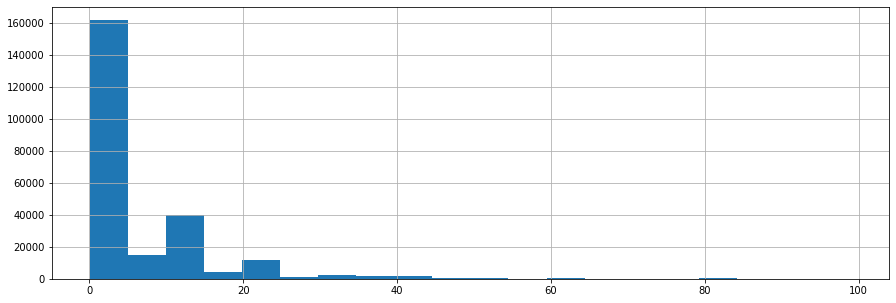

In [8]:
df[df['Qnty']<100]['Qnty'].hist(figsize=(15,5), bins=20);

Есть некоторое количество строк с отрицательной выручкой, давайте взгляним на них.

In [9]:
df[df['Revenue']<0]

,Name,Segment,Invoice,Date,Level1,Level2,Level3,Level4,SKU,Qnty,Revenue,Cost,Profit
126257,гапа,VIP,Фр00-011721,2016-01-09,КОНДИТЕРСКИЕ ИЗДЕЛИЯ,Восточные сладости,Конфеты,NaN,Ирис Тимоша 250г конфеты со сгущеным молоком 1...,2.00,-26.05,85.12,-111.17
171450,гапа,VIP,Фр00-000214,2016-12-01,КОНДИТЕРСКИЕ ИЗДЕЛИЯ,Восточные сладости,"Рахат-лукум, чак-чак, щербет",NaN,Щербет Тимоша 250г молочно-ореховый 1/16шт Россия,1.00,-18.69,38.63,-57.32


Скорее всего возврат на небольшую сумму и количество. Удалим эти строки из массива.

In [10]:
df.drop(df.loc[df['Revenue']<0].index, inplace=True)

Стоит внимательно посмотреть и на строки с экстремально большой выручкой.

In [11]:
df[df['Revenue']>100000]

,Name,Segment,Invoice,Date,Level1,Level2,Level3,Level4,SKU,Qnty,Revenue,Cost,Profit
0,ярослава,Ho-Re-Ka,Фр00-017166,2016-10-28,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",200.00,"276,000.00","160,164.12","115,835.88"
1,емилий,Ho-Re-Ka,Фр00-015446,2016-11-14,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",100.00,"138,000.00","80,000.00","58,000.00"
2,ярослава,Ho-Re-Ka,Фр00-013330,2016-09-30,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",77.00,"110,033.00","63,140.00","46,893.00"
3,ярослава,Ho-Re-Ka,Фр00-013196,2016-09-30,HoReCa,ЗАМОРОЗКА,Мясо говядины,NaN,"Говядина вырезка 1,4-1,8кг Tenderloin с/м Браз...",75.00,"107,175.00","61,500.00","45,675.00"
76,настас,Регион 6,00UT-002818,2017-03-14,ЗАМОРОЗКА,Мясные полуфабрикаты,"Сосиски, сардельки",NaN,Сосиски Обнинские 1/5 Молочные вес Россия,"1,500.00","225,750.00","120,000.00","105,750.00"
4554,анатолька,Ho-Re-Ka,Фр00-011175,2016-08-22,HoReCa,ЗАМОРОЗКА,"Картофель фри, дольки, ростисы",NaN,"Картофель Стар Жульен 2,5кг Классика 6мм 1/5шт...",500.00,"235,000.00","158,332.00","76,668.00"
4555,анатолька,Ho-Re-Ka,Фр00-006033,2016-05-16,HoReCa,ЗАМОРОЗКА,"Картофель фри, дольки, ростисы",NaN,"Картофель Стар Жульен 2,5кг Классика 6мм 1/5шт...",350.00,"172,200.00","112,000.00","60,200.00"
4556,анатолька,Ho-Re-Ka,Фр00-006265,2016-05-18,HoReCa,ЗАМОРОЗКА,"Картофель фри, дольки, ростисы",NaN,"Картофель Стар Жульен 2,5кг Классика 6мм 1/5шт...",250.00,"123,000.00","80,000.00","43,000.00"
5646,людаха,Регион 5,Фр00-016520,2016-05-10,ЗАМОРОЗКА,Морепродукты,"Креветки, улитки, крабовое мясо",NaN,Креветка 1кг 16/20 б/г с/м 1/10шт Китай 40% глаз.,300.00,"183,600.00","144,000.00","39,600.00"
5652,людаха,Регион 5,00UT-000681,2017-01-02,ЗАМОРОЗКА,Морепродукты,"Креветки, улитки, крабовое мясо",NaN,Креветка Guolian OGOOD 1кг16/20 б/г с/м 1/10шт...,200.00,"149,400.00","118,400.00","31,000.00"


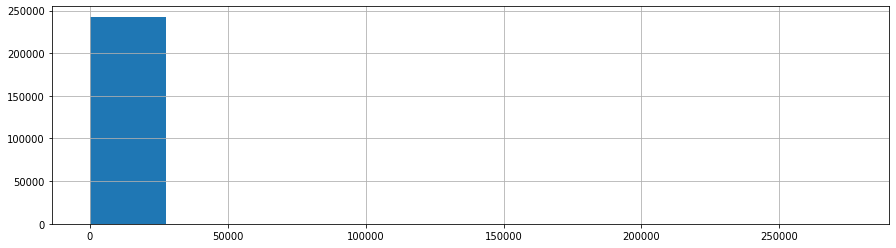

In [12]:
df['Revenue'].hist(figsize=(15,4));

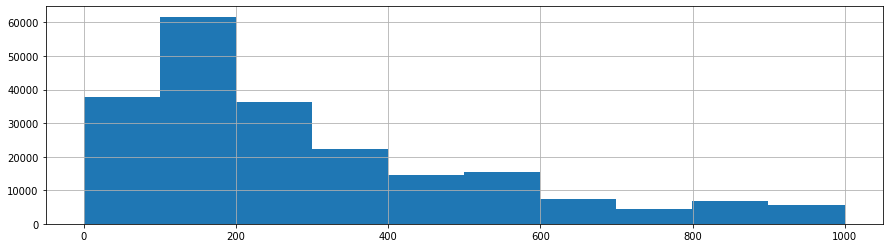

In [13]:
df[df['Revenue']<1000]['Revenue'].hist(figsize=(15,4));

Формально, и это видно по первой гистограмме, эти покупки являются выбросом. Основная масса покупок сосредоточена в диапазоне относительно небольших цифр. Но так как часть заказов повторялась, не будем корректирвать наш набор данных в части этих проводок. Но стоит держать их в уме, так как наличие таких выбросов может искажать часть результатов анализов, например, при выполнении кластеризации. 

## Выбросы в разрезе заказов

До этого мы смотрели выбросы в части отдельных строк набора данных. Ниже мы сгруппируем все результаты до заказа (группировка по номеру документа) и рассмотрим на предмет выбросов.

In [14]:
# сводная таблица
df_invoice=df.pivot_table(values=['Date', 'Name', 'Segment', 'Revenue', 'Qnty', 'Profit'], index='Invoice',
                        aggfunc={ 'Date': 'first', 'Name':'first', 'Segment':'first', 'Revenue': np.sum, 
                                 'Qnty':np.sum, 'Profit':np.sum}).reset_index()
df_invoice.head()

,Invoice,Date,Name,Profit,Qnty,Revenue,Segment
0,00UT-000001,2017-01-17,любаха,"8,238.00",26.00,"20,118.00",Ho-Re-Ka
1,00UT-000002,2017-01-17,стефана,"4,483.10",271.00,"11,738.00",Регион 5
2,00UT-000003,2017-01-17,игорюша,"1,983.70",41.00,"5,180.00",Регион 6
3,00UT-000004,2017-01-17,игорюша,475.00,5.00,875.00,Регион 6
4,00UT-000005,2017-01-17,антонидка,"1,570.79",93.00,"4,053.00",Регион 6


In [15]:
df_invoice.describe()

,Profit,Qnty,Revenue
count,"20,682.00","20,682.00","20,682.00"
mean,"2,755.33",92.94,"7,359.44"
std,"4,529.46",187.42,"12,221.28"
min,"-44,019.96",0.15,0.01
25%,652.60,12.50,"1,750.00"
50%,"1,405.95",42.22,"3,646.64"
75%,"2,964.62",102.00,"7,739.28"
max,"115,835.88","9,377.00","276,000.00"


Стандартно видим наличие экстремально больших счетов по сумме и количеству едениц товаров в счете. Посмотрим на них внимательнее.

In [16]:
df_invoice[df_invoice['Revenue']>200000]

,Invoice,Date,Name,Profit,Qnty,Revenue,Segment
2596,00UT-002818,2017-03-14,настас,"105,750.00","1,500.00","225,750.00",Регион 6
14460,Фр00-011175,2016-08-22,анатолька,"76,668.00",500.00,"235,000.00",Ho-Re-Ka
19795,Фр00-017166,2016-10-28,ярослава,"115,835.88",200.00,"276,000.00",Ho-Re-Ka


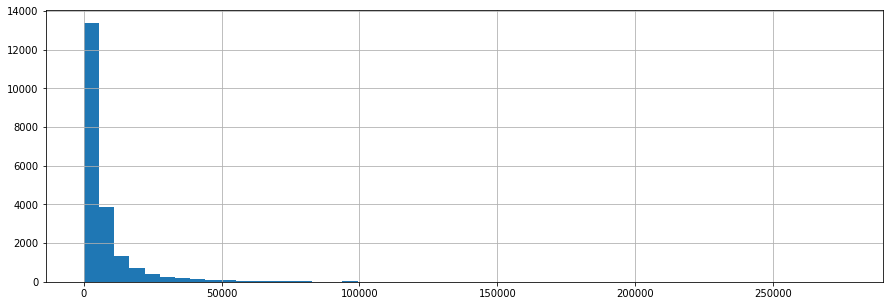

In [17]:
df_invoice['Revenue'].hist(figsize=(15,5), bins=50);

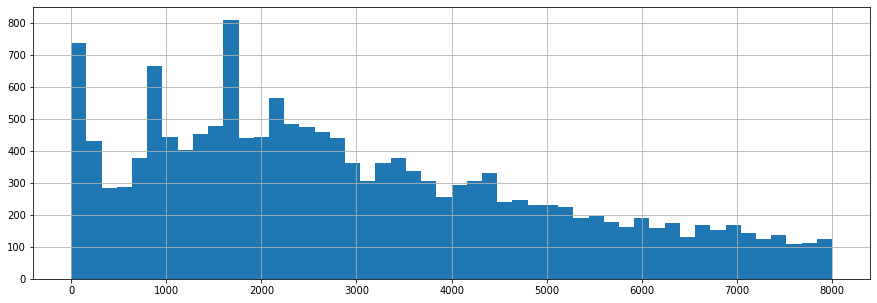

In [18]:
df_invoice[df_invoice['Revenue']<8000]['Revenue'].hist(figsize=(15,5), bins=50);

Это уже известные нам заказы. Оставим из в общем массиве.В тоже время видим, что основная масса заказов лежит в диапазоне до 3600 тыс рублей. 

## Выбросы в разрезе клиентов

Осталось рассмотреть выбросы в разерезе клиентов. Сгруппируем данные по клиентам. 

In [19]:
df_name=pd.pivot_table(df, values=['Revenue', 'Qnty', 'Profit', 'Segment'], index=['Name'], aggfunc={'Revenue':np.sum, 'Qnty': np.sum, 
                                    'Profit':np.sum, 'Segment':'first'}).reset_index()
df_name.head()

,Name,Profit,Qnty,Revenue,Segment
0,авдотьюшка,"6,260.73",125.00,"15,214.00",Регион 4
1,авдуся,"41,284.49",688.00,"120,284.40",Офис
2,агриппа,"95,513.01","4,997.00","260,836.75",Регион 6
3,адя,"12,728.14","1,139.00","34,389.00",Регион 4
4,аида,"48,035.98","2,158.38","126,496.48",Регион 6


In [20]:
df_name.describe()

,Profit,Qnty,Revenue
count,609.00,609.00,609.00
mean,"93,572.75","3,156.18","249,930.77"
std,"488,031.03","18,083.11","1,367,971.80"
min,0.00,1.00,93.00
25%,"9,227.65",277.00,"26,006.00"
50%,"29,749.82",930.70,"81,989.00"
75%,"69,759.47","2,496.00","189,844.80"
max,"11,270,564.73","429,421.92","31,946,749.39"


75% клиентов принесли за три года выручку компании не более 70 тыс рублей. В тоже время есть клиент с выручкой в 11 млн.

In [21]:
df_name[df_name['Revenue']>1000000]

,Name,Profit,Qnty,Revenue,Segment
64,артемон,"488,898.43","2,829.87","1,316,746.27",Ho-Re-Ka
84,валентин,"540,818.63","6,891.49","1,532,919.40",Ho-Re-Ka
99,василиск,"426,487.71","16,969.38","1,111,049.10",VIP 2
132,вира,"431,001.85","16,085.21","1,109,164.72",VIP 2
160,гапа,"11,270,564.73","429,421.92","31,946,749.39",VIP
188,дареша,"1,139,856.35","43,291.09","3,180,998.47",VIP 2
230,емилий,"1,118,098.11","6,943.95","3,251,677.10",Ho-Re-Ka
266,иулий,"415,312.34","16,956.00","1,137,401.80",VIP 2
267,кара,"1,739,462.19","55,616.68","4,610,370.36",VIP
288,корней,"730,709.85","33,055.75","2,067,459.98",Регион 1


Клиент "Гапа" - это виртуальный клиент, на котрого записывались все розничные продажи. Для чистоты эксперимента его также надо бы удалить, так как он не является типовым ни по каким параметрам.

In [22]:
df.drop(df.loc[df['Name']=='гапа'].index, inplace=True)

*После очистки от выбросов все группировки надо перестроить.*

Даже простейший анализ на выбросы учетных данных, приводит к появлению большого списка вопросов как к качеству учета, так и его адекватности. Исключений, когда данные не содержали бы ошибок/искажений я еще не встречал. 

Давайте перейдем к анализу.

# Вклад клиентов по годам

Первое, что полезно посомтреть это на топ самых значимых клиентов и как он менялся погодам. Сгруппируем данные в разрезе каждого из документов, по которым была совершена продажа. 

In [23]:
# перестраиваем
df_invoice=df.pivot_table(values=['Date', 'Name', 'Segment', 'Revenue', 'Qnty', 'Profit'], index='Invoice',
                        aggfunc={ 'Date': 'first', 'Name':'first', 'Segment':'first', 'Revenue': np.sum, 
                                 'Qnty':np.sum, 'Profit':np.sum}).reset_index()

Для упрощения анализа добавим столбец с годом, когда была соверщена продажа и сформируем список годов (нужен в технических целях).

In [24]:
df_invoice['InvoiceYear']=df_invoice['Date'].apply(lambda x: x.year)
ya=df_invoice['InvoiceYear'].unique()
ya.sort()
ya

array([2015, 2016, 2017], dtype=int64)

In [25]:
# список по годам в виде строк, нужен для оформления графиков
ya2=[]
for i in ya:
    ya2.append(str(i))

Год:  2015 ------------------------------


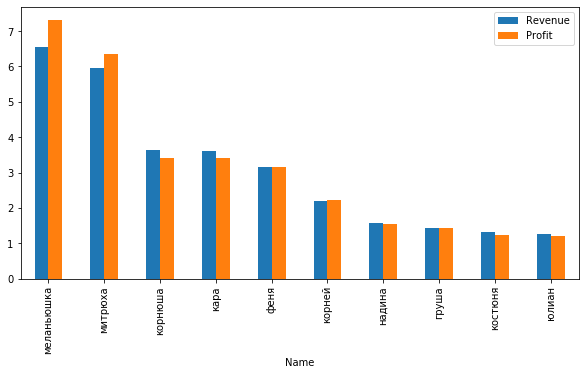

Всего активных клиентов в году:  367
Год:  2016 ------------------------------


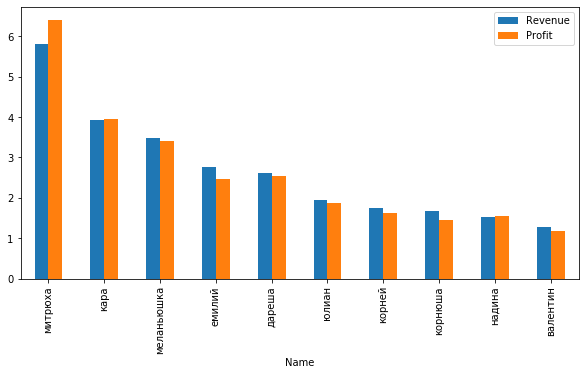

Всего активных клиентов в году:  530
Год:  2017 ------------------------------


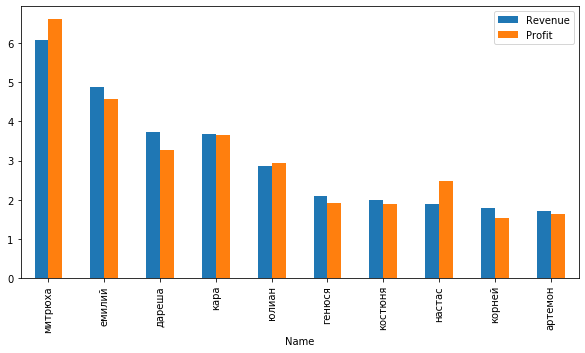

Всего активных клиентов в году:  398


In [26]:
for i in ya:
    print('Год: ', i, '------------------------------')
    df_ya=df_invoice[df_invoice['InvoiceYear']==i].groupby('Name')[['Revenue', 'Profit']].sum()
    df_ya.sort_values(by='Revenue', inplace=True, ascending=False)
    df_ya['Revenue']=df_ya['Revenue']*100/df_ya['Revenue'].sum()
    df_ya['Profit']=df_ya['Profit']*100/df_ya['Profit'].sum()
    #print(df_ya[:10])
    df_ya[:10].plot.bar(figsize=(10,5))
    plt.show()
    print('Всего активных клиентов в году: ', len(df_ya))

Выше мы видим, как менялся топ-10 клиентов по выручке по годам. Здесь есть как постоянные участники рейтинга, так и компании, которые мы потеряли. Это значимые потери. С ними надо провести отдельное расследование. И первый тривожный признак, у компании сокращается количество клиентов. 

Фактически, мы продолжаем как поиск искажений, так и знакомство с данными и формирование гипотез. Давайте взглянем, как менялись основные показатели в среднем по базе клиентов по годам.

In [27]:
res_voc=[['Year'], ['Revenue'], ['Profit'], ['Rent'], ['MeanQ'], ['QntyQ'], ['Chks'], ['Mean_chks']]
for y in ya:
    df_agg=df_invoice[df_invoice.InvoiceYear==y]
    df_agg_2=df_agg.groupby('Invoice')[['Revenue', 'Profit']].sum()
    #print(len(df_agg_2), df_agg_2['Выручка'].sum(), df_agg_2['Прибыль'].sum(), df_agg_2['Прибыль'].sum()/df_agg_2['Выручка'].sum())
    
    q_qlients=len(df_agg['Name'].unique())
    
    res_voc[0].append(y)
    res_voc[1].append(df_agg_2['Revenue'].sum())
    res_voc[2].append(df_agg_2['Profit'].sum())
    res_voc[3].append(df_agg_2['Profit'].sum()/df_agg_2['Revenue'].sum())
    res_voc[4].append(df_agg_2['Revenue'].sum()/q_qlients)
    res_voc[5].append(q_qlients)
    res_voc[6].append(len(df_agg_2))
    res_voc[7].append(df_agg_2['Revenue'].sum()/len(df_agg_2))

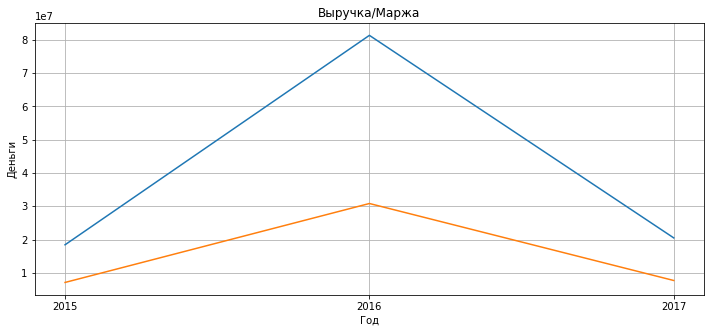

In [28]:
plt.figure(figsize=(12, 5))
plt.title("Выручка/Маржа") # заголовок
plt.xlabel("Год")         # ось абсцисс
plt.ylabel("Деньги")    # ось ординат
plt.grid()              # включение отображение сетки
plt.xticks(ya)
plt.plot(res_voc[0][1:], res_voc[1][1:], res_voc[0][1:], res_voc[2][1:]);  # построение графика

На гарфике выше видим, что маржинальная и прибыль сокращались практически синхронно. Хотя, размах выручки, все таки, выше. 

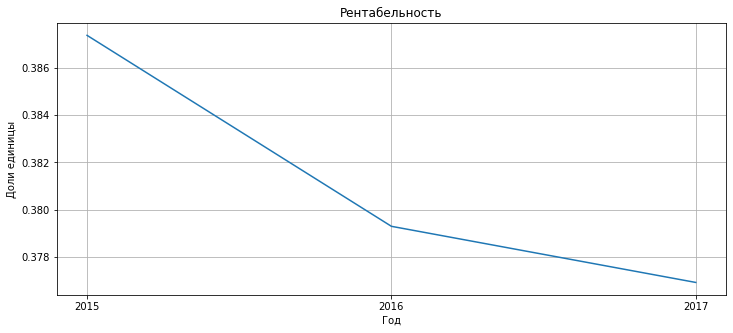

In [29]:
plt.figure(figsize=(12, 5))
plt.title("Рентабельность") # заголовок
plt.xlabel("Год")         # ось абсцисс
plt.ylabel("Доли единицы")    # ось ординат
plt.xticks(ya)
plt.grid()              # включение отображение сетки
plt.plot(res_voc[0][1:], res_voc[3][1:]);  # построение графика

Действительно, с ростом выручки, упала рентабельность. Но что печально, с паданием выручки, рентабельность продолжала падать. Что говорит о том, что компания теряла наиболее прибыльных клиентов. Хотя падение и не было столь большим. Отчасти, впечатление "трагедии" формирует график со смещенными осями. 

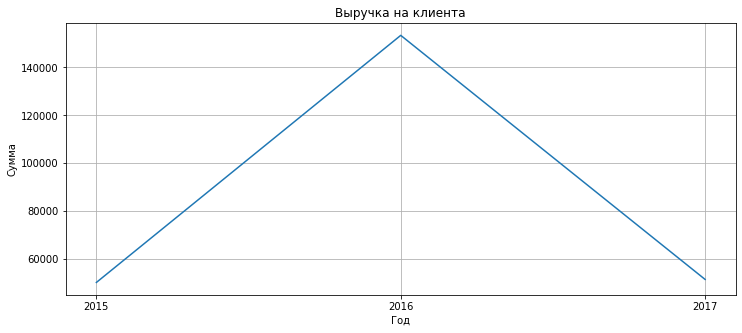

In [30]:
plt.figure(figsize=(12, 5))
plt.title("Выручка на клиента") # заголовок
plt.xlabel("Год")         # ось абсцисс
plt.ylabel("Сумма")    # ось ординат
plt.xticks(ya)
plt.grid()              # включение отображение сетки
plt.plot(res_voc[0][1:], res_voc[4][1:])  # построение графика

Показательно, что сократилась более чем в два раза средняя выручка на клиента. Все указывает на приобретение и потерю большого клиента или потерю по некоторым товарным позициям.

В данном случае, ситуция очевидная. Но на более длинном периоде времени эти показатели позволяют более детально посмотреть на ситуацию с продажами. 

Ниже ключевые параметры в виде таблицы. 

In [31]:
df_res_y=pd.DataFrame(res_voc[0][1:], columns=['Year'])
for i in res_voc[1:]:
    df_res_y[i[0]]=i[1:]
df_res_y

,Year,Revenue,Profit,Rent,MeanQ,QntyQ,Chks,Mean_chks
0,2015,"18,450,980.00","7,147,248.90",0.39,"50,275.15",367,2205,"8,367.79"
1,2016,"81,299,831.57","30,837,053.19",0.38,"153,395.91",530,13839,"5,874.69"
2,2017,"20,510,280.02","7,730,936.70",0.38,"51,533.37",398,3620,"5,665.82"


In [32]:
df_res_y.columns

Index(['Year', 'Revenue', 'Profit', 'Rent', 'MeanQ', 'QntyQ', 'Chks',
       'Mean_chks'],
      dtype='object')

Расшифровка кодировок полей:
* 'Year' год
* 'Revenue' выручка
* 'Profit' прибыль
* 'Rent' рентабельность
* 'MeanQ' средняя выручка на клиента
* 'QntyQ' количество клиентов 
* 'Chks' количество чеков
* 'Mean_chks' средний чек

Ниже интересно посмотреть именно динамику изменений ключевых показателей год к году. 

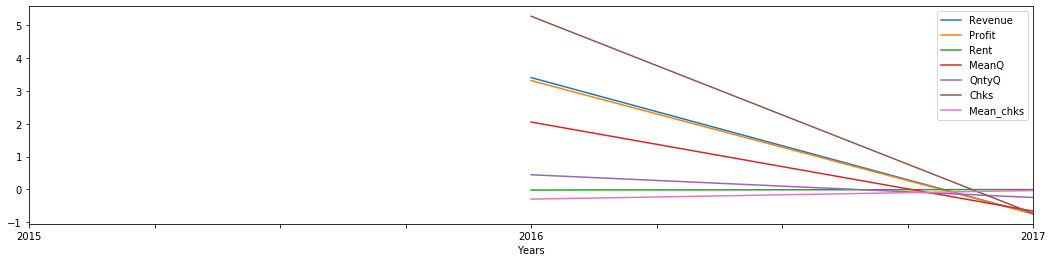

In [33]:
dfp=df_res_y[['Revenue', 'Profit', 'Rent', 'MeanQ', 'QntyQ', 'Chks', 'Mean_chks']].pct_change()
dfp['Years']=ya2
dfp.plot(kind='line',x='Years',y=['Revenue', 'Profit', 'Rent', 'MeanQ', 'QntyQ', 'Chks', 'Mean_chks'], figsize=(18,4));

Мы видим, что рентабельность, средний чек изменились не столь принципиально на фоне падения количества чеков (заказов), что привело к падению и показателей выручки и прибыли.

Небольшое примечание. Так как у нас всего три года, не все графики и анализы по настоящему наглядны и показательны. 

Ожна из гипотез, что мы потеряли больших клиентов с регулярными заказами и сместились в область клиентов с разовыми заказами. Давайте проверим эту гипотезу. 

Ниже топ-5 клиентов по количеству заказов в году.

In [34]:
for i in ya:
    print('Год: ', i)
    print(df_invoice[df_invoice.InvoiceYear==i].groupby('Name')['Revenue'].count().sort_values(ascending=False)[:5])

Год:  2015
Name
митрюха       178
меланьюшка     89
корнюша        84
линка          29
надина         27
Name: Revenue, dtype: int64
Год:  2016
Name
митрюха       1264
корнюша        281
дареша         208
маргуша        184
меланьюшка     164
Name: Revenue, dtype: int64
Год:  2017
Name
митрюха    429
дареша      91
филипп      58
маргуша     47
надина      41
Name: Revenue, dtype: int64


Мы видим, что и по клиенту "Митрюха" и по всем топовым клиентам в 2016 году было больше заказов. 

Ниже мы посмотрим, ка кизменились основные показатели: количество заказов, выручка и прибыль по годам в разрезе клиентов кто сделал одну, 2-3, от 3 до 10 и больше 10-ти заказов. 

In [35]:
arr_y_z=[]
arr_y_v=[]
arr_y_m=[]

for y in ya:
    df_agg=df_invoice[(df_invoice.InvoiceYear==y)]
    
    df_agg_2=df_agg.groupby('Name')['Invoice', 'Revenue', 'Profit'].agg(list)
    df_agg_2['Qnty']=df_agg_2['Invoice'].apply(lambda x: len(set(x)))
    df_agg_2['Revenue']=df_agg_2['Revenue'].apply(lambda x: np.array(x).sum())
    df_agg_2['Profit']=df_agg_2['Profit'].apply(lambda x: np.array(x).sum())
    
    t=[]
    t.append((df_agg_2['Qnty']==1).count())
    t.append(df_agg_2[(df_agg_2['Qnty']>1) & (df_agg_2['Qnty']<4)]['Qnty'].count())
    t.append(df_agg_2[(df_agg_2['Qnty']>3) & (df_agg_2['Qnty']<11)]['Qnty'].count())
    t.append((df_agg_2['Qnty']>10).sum())
    arr_y_z.append(t)
    
    t=[]
    t.append(df_agg_2[df_agg_2['Qnty']==1]['Revenue'].sum())
    t.append(df_agg_2[(df_agg_2['Qnty']>1) & (df_agg_2['Qnty']<4)]['Revenue'].sum())
    t.append(df_agg_2[(df_agg_2['Qnty']>3) & (df_agg_2['Qnty']<11)]['Revenue'].sum())
    t.append(df_agg_2[df_agg_2['Qnty']>10]['Revenue'].sum())
    arr_y_v.append(t)
    
    t=[]
    t.append(df_agg_2[df_agg_2['Qnty']==1]['Profit'].sum())
    t.append(df_agg_2[(df_agg_2['Qnty']>1) & (df_agg_2['Qnty']<4)]['Profit'].sum())
    t.append(df_agg_2[(df_agg_2['Qnty']>3) & (df_agg_2['Qnty']<11)]['Profit'].sum())
    t.append(df_agg_2[df_agg_2['Qnty']>10]['Profit'].sum())
    arr_y_m.append(t)

In [36]:
(df_agg_2['Qnty']==1).count()

398

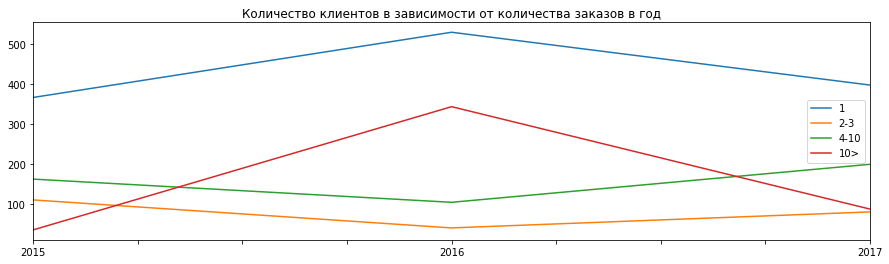

In [37]:
df_z=pd.DataFrame(arr_y_z, columns=['1', '2-3', '4-10', '10>'], index=ya2)
df_z.plot(figsize=(15,4), title='Количество клиентов в зависимости от количества заказов в год');

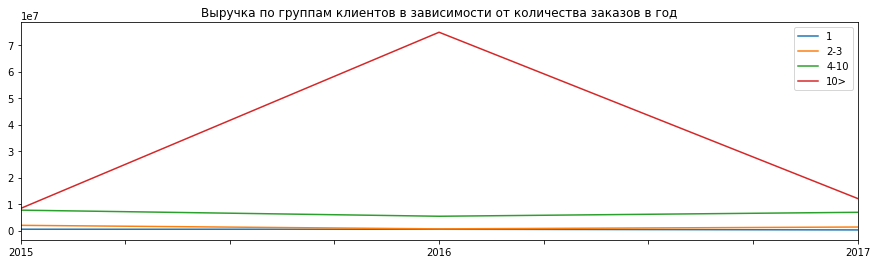

In [38]:
df_v=pd.DataFrame(arr_y_v, columns=['1', '2-3', '4-10', '10>'], index=ya2)
df_v.plot(figsize=(15,4), title='Выручка по группам клиентов в зависимости от количества заказов в год')

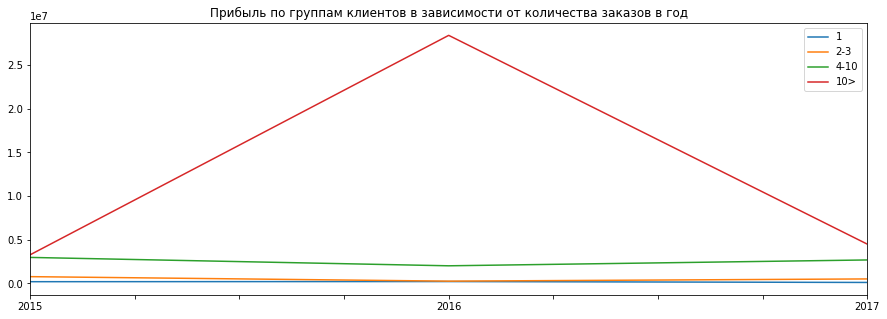

In [39]:
df_m=pd.DataFrame(arr_y_m, columns=['1', '2-3', '4-10', '10>'], index=ya2)
df_m.plot(figsize=(15,5), title='Прибыль по группам клиентов в зависимости от количества заказов в год')

Мы видим, что в 2017 году приросли клиенты которые делают 2-3 заказа и 4-10 заказов. Но этот прирост не смог решить ситуацию с потерянными крупными клиентами.

Давайте посмотрим внимательно на сгменты, которые определила компания.

## Динамика по годам в разрезе сегментов

In [40]:
df.Segment.unique()

array(['Ho-Re-Ka', 'Офис', 'Разовый покупатель', 'Регион 3', 'Регион 6',
       'Регион 7', 'VIP', 'Регион 5', 'VIP 2', 'Регион 1', 'Регион 2',
       'Регион 4', nan, 'Не определен'], dtype=object)

Компания выделали для рабты 13 сегментов. 

Значение nan указывает, что есть клиенты, где это поле не заполенно.

In [41]:
df[df.Segment.isna()]['Name'].unique()

array(['елисавета', 'лукаря', 'мина', 'алинка', 'тима', 'марлен',
       'никитий', 'меланья'], dtype=object)

Этих 8 клиентов отнесем к сегменту "Не определен".

In [42]:
df.loc[df.Segment.isna(), 'Segment']='Не определен'

Ниже статистика по количеству киентов в сегменте.

In [43]:
df.pivot_table(values=['Segment'], index='Name', aggfunc={ 'Segment': 'first'}).groupby('Segment')['Segment'].count()

Segment
Ho-Re-Ka               68
VIP                     3
VIP 2                  15
Не определен           11
Офис                  128
Разовый покупатель      2
Регион 1               41
Регион 2               42
Регион 3               30
Регион 4               82
Регион 5               98
Регион 6               85
Регион 7                3
Name: Segment, dtype: int64

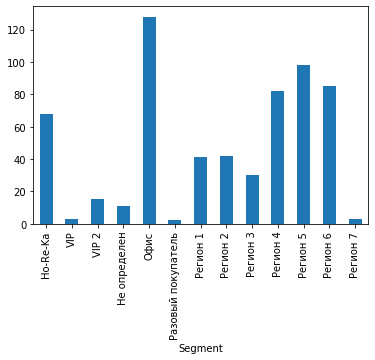

In [44]:
df.pivot_table(values=['Segment'], index='Name', aggfunc={ 'Segment': 'first'}).groupby('Segment')['Segment'].count().plot.bar();

Самомые массовые сегменты это "офис", регионы 4-6 и Ho-Re-Ka.

График ниже показывает, что не все клиенты создают не пропорциональную нагрузку относительно количества. 

Text(0.5, 1.0, 'Количество заказов')

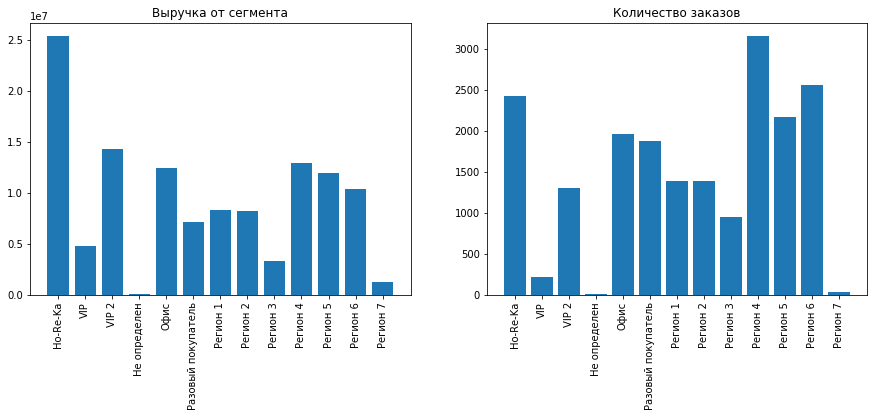

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
data1=df_invoice.groupby('Segment')['Revenue'].sum()
axs[0].bar(data1.index, data1)
axs[0].set_xticklabels(data1.index, fontsize = 10, rotation='vertical')
axs[0].set_title('Выручка от сегмента')
data2=df_invoice.groupby('Segment')['Revenue'].count()
axs[1].bar(data2.index, data2)
axs[1].set_xticklabels(data2.index, fontsize = 10, rotation='vertical')
axs[1].set_title('Количество заказов')

Ho-Re-Ka -> 10,757.0 руб.
Офис -> 5,735.0 руб.
Разовый покупатель -> 3,746.0 руб.
Регион 3 -> 3,580.0 руб.
Регион 6 -> 3,724.0 руб.
Регион 7 -> 33,850.0 руб.
VIP -> 20,989.0 руб.
Регион 5 -> 5,079.0 руб.
VIP 2 -> 10,804.0 руб.
Регион 1 -> 5,776.0 руб.
Регион 2 -> 5,851.0 руб.
Регион 4 -> 3,866.0 руб.
Не определен -> 151.0 руб.


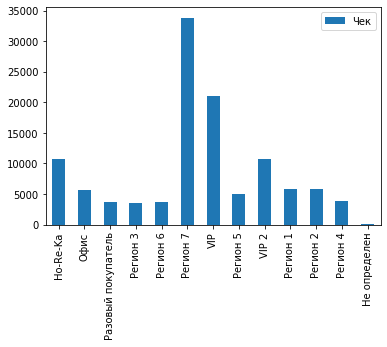

In [46]:
segment=df.Segment.unique()

#средний чек по сегментам
m=[]
for s in segment:
    t=df_invoice[(df_invoice.InvoiceYear==2016) & (df_invoice.Segment==s)]['Revenue'].sum()/df_invoice[(
        df_invoice.InvoiceYear==2016) & (df_invoice.Segment==s)]['Revenue'].count()
    print("%s -> %s руб." %(s, '{:,}'.format(round(t))))
    m.append(t)
pd.DataFrame(m, index=segment, columns=['Чек']).plot.bar();

Ожидаемо сильно отличается средний чек по сегментам, если брать результаты 2016 года. 

Посмотрим, как менялась выручка по сегментам по годам.

In [47]:
segment_revenue=[]
for y in ya:
    t=[]
    for s in segment:
        t.append(df_invoice[(df_invoice.InvoiceYear==y) & (df_invoice.Segment==s)]['Revenue'].sum())
    segment_revenue.append(t)

In [48]:
df_seg_rev=pd.DataFrame(segment_revenue, columns=segment, index=ya)
df_seg_rev

,Ho-Re-Ka,Офис,Разовый покупатель,Регион 3,Регион 6,Регион 7,VIP,Регион 5,VIP 2,Регион 1,Регион 2,Регион 4,Не определен
2015,"2,061,691.03","4,389,844.79","1,100,820.33","439,282.21","1,258,471.99","79,563.04","694,970.36","1,561,300.98","2,195,748.20","1,168,421.55","1,504,214.39","1,970,964.58","25,686.55"
2016,"17,296,460.51","7,886,253.79","4,746,120.03","2,434,578.91","6,956,328.75","846,239.99","3,253,236.87","7,908,665.99","9,745,478.59","5,678,108.79","5,535,271.73","8,892,400.39",151.20
2017,"6,009,552.86","161,538.59","1,243,622.31","455,507.65","2,093,891.35","268,250.00","785,003.13","2,471,797.64","2,339,315.29","1,422,281.06","1,139,381.70","2,045,985.78",941.45


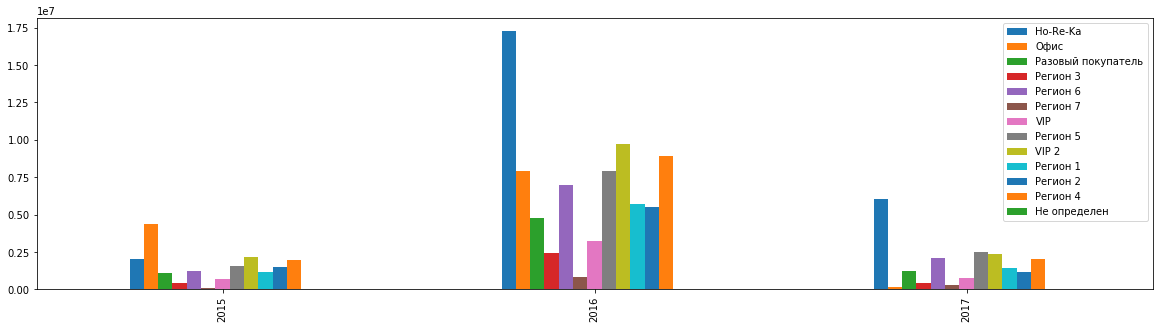

In [49]:
df_seg_rev.plot.bar(figsize=(20,5)).legend(bbox_to_anchor=(1, 1));

Мы видим, что в 2017 году просели все сегменты. Практически полностью исчез сегмент "Офис". Разобраться с устойчивостью сегментов и пожизненной ценностью нам поможет такая метрика как коэффициент удержания.

## Коэффициенты удержания и пожизненная ценность клиента

Подготовим необходимые данные. Уточним по клиентам дату начала и окончания сотрудничества. 

In [50]:
df_t1=pd.pivot_table(df, values=['Date'], index=['Name'], aggfunc={'Date': min}).reset_index()
df_t1.columns=['Name', 'start_date']
df_t2=pd.pivot_table(df, values=['Date'], index=['Name'], aggfunc={'Date': max}).reset_index()
df_t2.columns=['Name', 'last_date']
df_name=pd.merge(df_name, df_t1, on='Name')
df_name=pd.merge(df_name, df_t2, on='Name')

df_name['start_year']=df_name['start_date'].apply(lambda x: x.year)
df_name['last_year']=df_name['last_date'].apply(lambda x: x.year)
df_name.head()

,Name,Profit,Qnty,Revenue,Segment,start_date,last_date,start_year,last_year
0,авдотьюшка,"6,260.73",125.00,"15,214.00",Регион 4,2017-03-21,2017-03-22,2017,2017
1,авдуся,"41,284.49",688.00,"120,284.40",Офис,2015-07-12,2016-11-01,2015,2016
2,агриппа,"95,513.01","4,997.00","260,836.75",Регион 6,2015-04-11,2017-11-01,2015,2017
3,адя,"12,728.14","1,139.00","34,389.00",Регион 4,2015-09-11,2016-05-23,2015,2016
4,аида,"48,035.98","2,158.38","126,496.48",Регион 6,2015-02-11,2016-12-09,2015,2016


In [51]:
r=[]
start=len(df_name[(df_name['start_year']==ya[0])])
for y in ya[1:]:
    r.append(len(df_name[(df_name['start_year']<y) & (df_name['last_year']>=y)])/start)
    start=len(df_name[(df_name['start_year']<=y) & (df_name['last_year']>=y)])
r

[0.9246231155778895, 0.664804469273743]

Выше мы рассчитали коэффициенты удержания для 2016 года по отношению к 2015 и 2017/2016 года.

Упрощенно, это показатель, какой процент клиентов перешел с вами из одного года в другой. В данном случае мы видим катастрофическое падение коэфициента удержания. Но считать его в целом по компании не совсем справедливо. Более корректно считать по сегментам. В том числе и по каналам привлечения.

Ниже график, как менялся коэффициент удержания по годам.

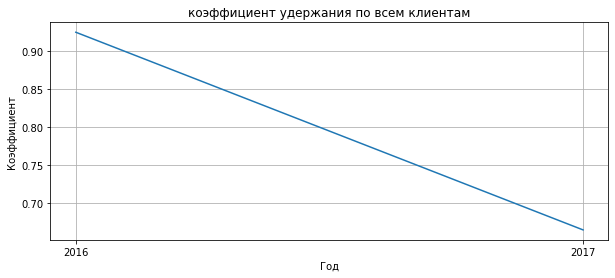

In [52]:
plt.figure(figsize=(10, 4))
plt.title("коэффициент удержания по всем клиентам") # заголовок
plt.xlabel("Год")         # ось абсцисс
plt.ylabel("Коэффициент")    # ось ординат
plt.xticks(ya)
plt.grid()              # включение отображение сетки
plt.plot(ya[1:], r);

Любопытно посмотреть, как изменялась выручка по компании по годам от новых и старых (для конкретного года) клиентов.  В нашем случае, компания теряла как старых, так и недобирала новых клиентов.

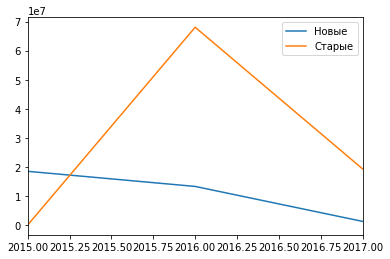

In [53]:
df_t=df.groupby('Name')['Date'].min().reset_index()
df_t.columns=['Name', 'StartYear']
df_invoice=df_invoice.merge(df_t, on='Name')
df_invoice['StartYear']=df_invoice['StartYear'].apply(lambda x: x.year)

rev=[]
for y in ya:
    nw=df_invoice[(df_invoice['StartYear']==y) & (df_invoice['InvoiceYear']==y)]['Revenue'].sum()
    od=df_invoice[(df_invoice['StartYear']<y) & (df_invoice['InvoiceYear']==y)]['Revenue'].sum()
    rev.append([nw,od])

pd.DataFrame(rev, index=ya, columns=['Новые', 'Старые']).plot();

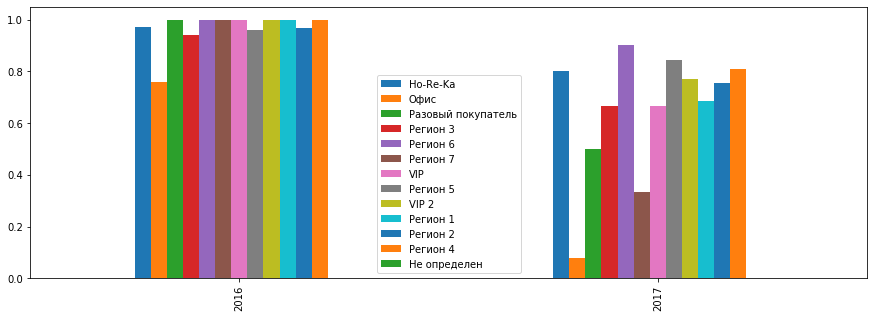

In [54]:
#по сегментам
ss=[]
for s in segment:
    r=[]
    start=len(df_name[(df_name['start_year']==ya[0]) & (df_name['Segment']==s)])
    for y in ya[1:]:
        r.append(len(df_name[(df_name['start_year']<y) & (df_name['last_year']>=y) & (df_name['Segment']==s)])/start)
        start=len(df_name[(df_name['start_year']<=y) & (df_name['last_year']>=y) & (df_name['Segment']==s)])
    ss.append(r)
df_r=pd.DataFrame(list(map(list, zip(*ss))), index=ya[1:], columns=segment)
df_r.plot.bar(figsize=(15,5));

In [55]:
df_r

,Ho-Re-Ka,Офис,Разовый покупатель,Регион 3,Регион 6,Регион 7,VIP,Регион 5,VIP 2,Регион 1,Регион 2,Регион 4,Не определен
2016,0.97,0.76,1.00,0.94,1.00,1.00,1.00,0.96,1.00,1.00,0.97,1.00,0.00
2017,0.80,0.08,0.50,0.67,0.90,0.33,0.67,0.85,0.77,0.69,0.76,0.81,0.00


Выше мы видим, в каких сегментах произошло основное падение. В частности, относительно мало мы потеряли клиентов в сегменте "Ho-Re-Ka" и "Регион 6", катастрофическое падение в сегменте "Офис" и "Регион 7".

Чаще всего, коэффициенты удержания достаточно стабильны по сегментам. Если не происходит катострофы. И это один из важнейших показателей маркетинга/продаж на стагнирующем и тем более падающем рынке. К тому же, этот коэффициент позволяет оценить пожизненную ценность клиента для компании, те наиболее вероятный доход среднего клиента из сегмента. Рассчитывается по формуле:

**CLV=m*(r/(1+i-r))**

Где,
* CLV (Customer Livetime Value) пожизнеснная ценность клиента
* m средняя маржинальная прибыль на клиента в год
* r коэффициент удержания для сегмента
* i ставка дисконтирования. Равна стоимости денег для компании плюс воспринимаемый риск. Учитывается так как считаем доход от клиента на горизонте более года. В нашем случае, пример равной 20%.

Посчитаем CLV клиентов на основании данных 2017 года.

In [56]:
df_invoice.head()

,Invoice,Date,Name,Profit,Qnty,Revenue,Segment,InvoiceYear,StartYear
0,00UT-000001,2017-01-17,любаха,"8,238.00",26.00,"20,118.00",Ho-Re-Ka,2017,2016
1,00UT-000862,2017-06-02,любаха,"9,745.20",34.00,"24,108.00",Ho-Re-Ka,2017,2016
2,00UT-001630,2017-02-20,любаха,"3,750.00",10.00,"9,000.00",Ho-Re-Ka,2017,2016
3,00UT-002116,2017-01-03,любаха,"7,638.50",21.00,"18,351.00",Ho-Re-Ka,2017,2016
4,00UT-002547,2017-09-03,любаха,772.88,6.00,"2,118.00",Ho-Re-Ka,2017,2016


In [57]:
df_r2=df_r.T.reset_index()
df_r2.columns=['Segment', '2016', '2017']

df_t=df_invoice[df_invoice.InvoiceYear==2017].groupby('Segment')['Name'].apply(list).reset_index()
df_t['Name_count']=df_t.Name.apply(lambda x: len(list(set(x))))
df_t=df_t.merge(df_invoice[df_invoice.InvoiceYear==2017].groupby('Segment')['Profit'].sum().reset_index(), on='Segment')
df_t['ProfitM']=df_t['Profit']/df_t['Name_count']
df_t=df_t.merge(df_r2, on='Segment')
df_t=df_t[['Segment', 'Name_count', '2017', 'ProfitM']]
df_t['CLV']=df_t['ProfitM']*(df_t['2017']/(1+0.2-df_t['2017']))
df_t.set_index('Segment', inplace=True)
df_t

,Name_count,2017,ProfitM,CLV
Segment,,,,
Ho-Re-Ka,54,0.80,"40,838.53","81,677.06"
VIP,2,0.67,"148,656.12","185,820.16"
VIP 2,12,0.77,"68,861.98","122,967.82"
Не определен,1,0.00,416.45,0.00
Офис,11,0.08,"5,487.49",387.81
Разовый покупатель,1,0.50,"510,521.75","364,658.39"
Регион 1,30,0.69,"16,953.95","22,605.27"
Регион 2,32,0.76,"13,356.96","22,804.56"
Регион 3,20,0.67,"8,519.73","10,649.66"


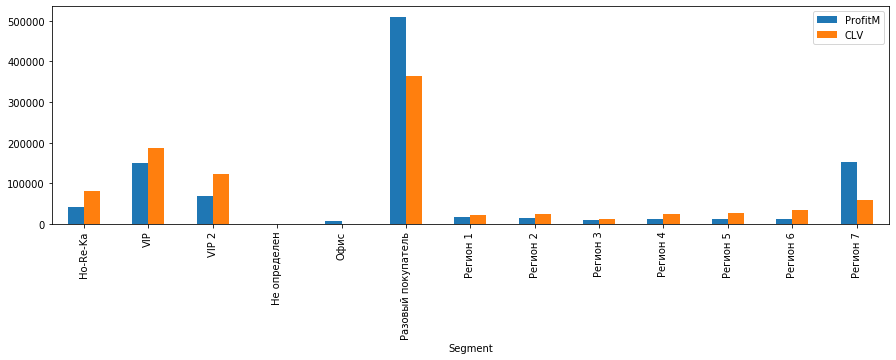

In [58]:
df_t[['ProfitM', 'CLV']].plot.bar(figsize=(15,4))

Чем может быть полезно CLV? Чаще всего в двух двух ситуация:
* сколько денег можем потратить на привлечение среднего клиента из сегмента;
* на каком сегменте сосредоточиться при ограниченном бюджете на привлечение или ситуации удержания.

Обратите внимание, что коэффициент удержания драматично влияет на пожизненную ценность клиента. Пока отбросим количество клиентов в сегменте, но обратите внимание, как резко падает привлекательность клиента исходя их CLV в сегментах "Разовый покупатель" и "Регион 7". Ориентируясь только на доходность клиента, мы не формируем фундамента продаж компании (график выручка от новых/старых клиентов). А порой на привлечение клиента (стоимость клиента, CAC - Customer acquisition cost) тратим больше, чем его пожизнеснная стоимость. 

Если говорить о нашей ситуации, то стоит сосредоточиться на наиболее массовых, стабильных и прибыльных сегментах "VIP" и "Ho-Re-Ka". 

Часто более адекватная информация об удержании и результах высоких показателей более понятна из когортного анализа.

# Когортный анализ

Суть данного вида анализа состоит в том, чтобы анализировать поведение групп людей или компанией, объединенных по какому-либо признаку во времени. В нашем случае, этим признаком будет год и квартал привлечения клиента.

Расчитаем когортный анализ погодам по всем клиентам.

In [59]:
all_r=[]
for i in range(0,len(ya)-1):
    start=len(df_name[(df_name['start_year']==ya[i])])
    t=[0 for x in range(i)]
    for j in range(i+1,len(ya)):
        t.append(round(len(df_name[(df_name['start_year']==ya[i]) & (df_name['last_year']>=ya[j])])/start,2))
    all_r.append(t)
pd.DataFrame(all_r, columns=ya[1:], index=ya[:-1])

,2016,2017
2015,0.92,0.62
2016,0.00,0.66


Мы видим, что из клиентов кто работал с нами с 2015 года в 2016 осталось 92%, а в 2017 - 62%. В тоже время их тех, кого мы привлекли в 2016 году, в 2017 году с нами осталось уже только 66%. Вывод напрашивается достаточно простой - ядро продаж компании, это старые и преданные клиенты. А на привлечение новых мы тратим больше, чем они нам приносят.

Давайте попробуем взглянуть на это через кварталы. Надо провести некотрые рассчеты.

In [60]:
df_name['MinPurchaseQuarter'] = df_name['start_date'].map(lambda date: 10*date.year + date.quarter)
df_name['MaxPurchaseQuarter'] = df_name['last_date'].map(lambda date: 10*date.year + date.quarter)

my_all=[]
min_y=df_name['start_year'].min()
max_y=df_name['last_year'].max()
max_date=df_name['MaxPurchaseQuarter'].max()
for y in range(min_y, max_y+1):
    for m in range(1,5):
        nl=y*10+m
        if nl>max_date: break
        my_all.append(nl)

In [61]:
all_r=[]
for i in range(len(my_all)):
    start=len(df_name[(df_name['MinPurchaseQuarter']==my_all[i])])
    if start==0: start=1
    t=[0 for x in range(i)]
    for j in range(i,len(my_all)):
        t.append(round(len(df_name[(df_name['MinPurchaseQuarter']==my_all[i]) & 
                                   (df_name['MaxPurchaseQuarter']>=my_all[j])])/start,2))
    all_r.append(t)
data=pd.DataFrame(all_r, columns=my_all, index=my_all)
data

,20151,20152,20153,20154,20161,20162,20163,20164,20171,20172,20173,20174
20151,1.00,1.00,1.00,1.00,0.96,0.94,0.93,0.89,0.67,0.55,0.51,0.32
20152,0.00,1.00,0.96,0.96,0.90,0.89,0.88,0.83,0.61,0.43,0.33,0.23
20153,0.00,0.00,1.00,0.93,0.88,0.83,0.78,0.73,0.59,0.51,0.46,0.32
20154,0.00,0.00,0.00,1.00,0.86,0.82,0.81,0.72,0.44,0.28,0.25,0.14
20161,0.00,0.00,0.00,0.00,1.00,0.99,0.99,0.97,0.79,0.61,0.50,0.35
20162,0.00,0.00,0.00,0.00,0.00,1.00,0.81,0.78,0.51,0.43,0.35,0.08
20163,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.68,0.52,0.40,0.40,0.28
20164,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.63,0.30,0.26,0.07
20171,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.28,0.26,0.05
20172,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Как всегда, человек лучше и быстрее воспринимает таблицы в виде графиков. В нашем случае, тепловых карт.

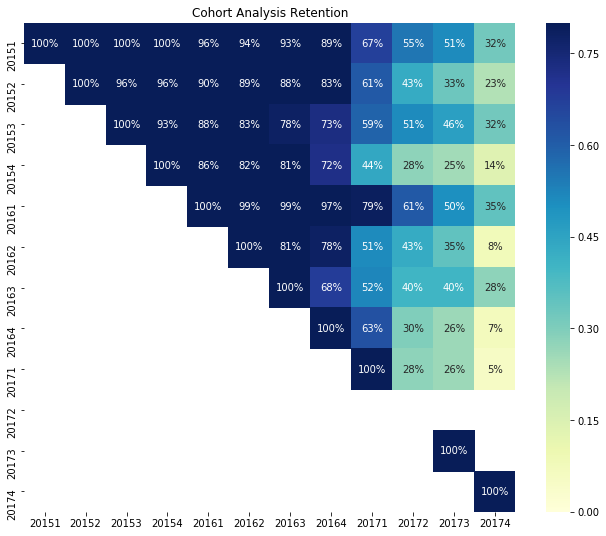

In [62]:
data[data==0]=np.nan

plt.figure(figsize = (11,9))
plt.title('Cohort Analysis Retention')
sns.heatmap(data = data, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.8,
            cmap = "YlGnBu")
plt.show()

Эта диграмма полностью подтверждает нашу гипотезу. Те клиенты, которые были с нами до и с 2015 года более стабильны и устойчивы. Новых мы не могли удерживать и в следующем квартале от нал уходило уже 72% (как пример, клиенты привлеченные в 1 квартале 2017 года). Мы тратили на их привлечение больше, чем получали доход. Это подрывало наш бизнес. Выручка расла, а вот прибыль компании падала. 

Когортный анализ полезно проводить не только в целом по компании, но и по:
* сегментам 
* каналам привлечения
* подразделениями
* товарным группам.

А также в разрезе выручки и прибыли.

Для профилактики ухода можно сегментировать клиентов внутри базы, назначив индивидуальные мероприятия по каждому. Это можно делать используя как машинное обучения для оценки риска потери клиента, так и существенно более простую технику RFM анализ.

# RFM

RFM аббревиатура (англ. Recency Frequency Monetary — давность, частота, деньги) — сегментация клиентов в анализе сбыта по лояльности.

Определяет три группы:
* Recency (давность) — давность сделки, чем меньше времени прошло с момента последней активности клиента, тем больше вероятность, что он повторит действие
* Frequency (частота) — количество сделок, чем больше каких-либо действий совершит клиент, тем больше вероятность того, что он его повторит в будущем
* Monetary (деньги) — сумма сделок, чем больше денег было потрачено, тем больше вероятность того, что он сделает заказ

Сегментируем нашу базу.

In [63]:
#Step 1: Create RFM Features for each customers
df_RFM = df.groupby('Name').agg({'Date': lambda y: (df['Date'].max().date() - y.max().date()).days,
                                        'Invoice': lambda y: len(y.unique()),  
                                        'Revenue': lambda y: round(y.sum(),2)})
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
Name,,,
митрюха,0,1985,"6,108,872.94"
кара,0,172,"4,610,370.36"
меланьюшка,259,273,"4,072,169.46"
емилий,0,73,"3,251,677.10"
дареша,30,340,"3,180,998.47"


In [64]:
df_RFM['R'] = pd.qcut(df_RFM['Recency'], 5, [5,4,3,2,1])
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], 5, [1,2,3,4,5])
df_RFM['M'] = pd.qcut(df_RFM['Monetary'], 5, [1,2,3,4,5])

df_RFM['RFM Score'] = np.array(df_RFM['R'].map(str)) + np.array(df_RFM['F'].map(str)) + np.array(df_RFM['M'].map(str))
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM Score
Name,,,,,,,
митрюха,0,1985,"6,108,872.94",5,5,5,555
кара,0,172,"4,610,370.36",5,5,5,555
меланьюшка,259,273,"4,072,169.46",3,5,5,355
емилий,0,73,"3,251,677.10",5,5,5,555
дареша,30,340,"3,180,998.47",5,5,5,555


Выше вы видите част таблицы с клиентами, где они разделены на когорты (по 20%) по всем трем критериям. RFM Score - столбец, где собран рейтинг из эти трех критериев. В зависимости от обобщенного рейтинга, каждого из клиентов можно отнести к одному из сегментов. 

In [65]:
segt_map = {
    r'[1-2][1-2]': 'потерянные',
    r'[1-2][3-4]': 'риск потерять',
    r'[1-2]5': 'не терять',
    r'3[1-2]': 'спящие',
    r'33': 'нужно внимание',
    r'[3-4][4-5]': 'лояльные',
    r'41': 'многообещающие',
    r'51': 'новые',
    r'[4-5][2-3]': 'потенциально лояльные',
    r'5[4-5]': 'чемпионы'
}

df_RFM['Segment'] = np.array(df_RFM['R'].map(str)) + np.array(df_RFM['F'].map(str))
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)
df_RFM.sample(10)

,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
Name,,,,,,,,
поликсюша,359,63,"816,270.68",2,5,5,255,не терять
аннуся,0,37,"183,296.46",5,4,4,544,чемпионы
володяка,61,37,"218,644.25",4,4,4,444,лояльные
митрюша,738,2,"3,923.00",1,1,1,111,потерянные
данило,364,33,"91,682.79",2,4,3,243,риск потерять
нинуха,249,31,"62,699.10",3,3,3,333,нужно внимание
зиша,0,27,"160,379.41",5,3,4,534,потенциально лояльные
степаша,30,66,"146,808.45",5,5,4,554,чемпионы
ниноха,515,6,"2,200.65",1,2,1,121,потерянные


In [66]:
df_RFM[df_RFM['Segment']=='чемпионы']

,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
Name,,,,,,,,
митрюха,0,1985,"6,108,872.94",5,5,5,555,чемпионы
кара,0,172,"4,610,370.36",5,5,5,555,чемпионы
емилий,0,73,"3,251,677.10",5,5,5,555,чемпионы
дареша,30,340,"3,180,998.47",5,5,5,555,чемпионы
юлиан,30,127,"2,501,800.48",5,5,5,555,чемпионы
...,...,...,...,...,...,...,...,...
эвелина,0,59,"41,582.87",5,5,2,552,чемпионы
толюся,59,58,"28,464.95",5,5,2,552,чемпионы
римуля,60,38,"16,532.75",5,4,1,541,чемпионы


В данном случае, мы автоматически распределили клиентов по квинтилям (20% группы) и распределелили по сегментам согласно оригинальной методики. Но ее можно совершенствовать и адаптировать. Например:
* сразу отсечь клиентов которые не делали заказ больше какого то времени как потерянных. Этот период вполне можно расчитать на основе медианного времени между заказами по сегменту.
* ввести сегменмет супер-чемпионы, куда входили бы клиенты только с высокими показателями выручки и тд.

В частности, без учета этих особенностей картина у нас не столь плоха по структуре клиентской базы.

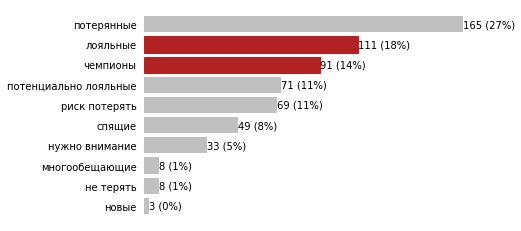

In [67]:
# count the number of customers in each segment
segments_counts = df_RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['чемпионы', 'лояльные']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

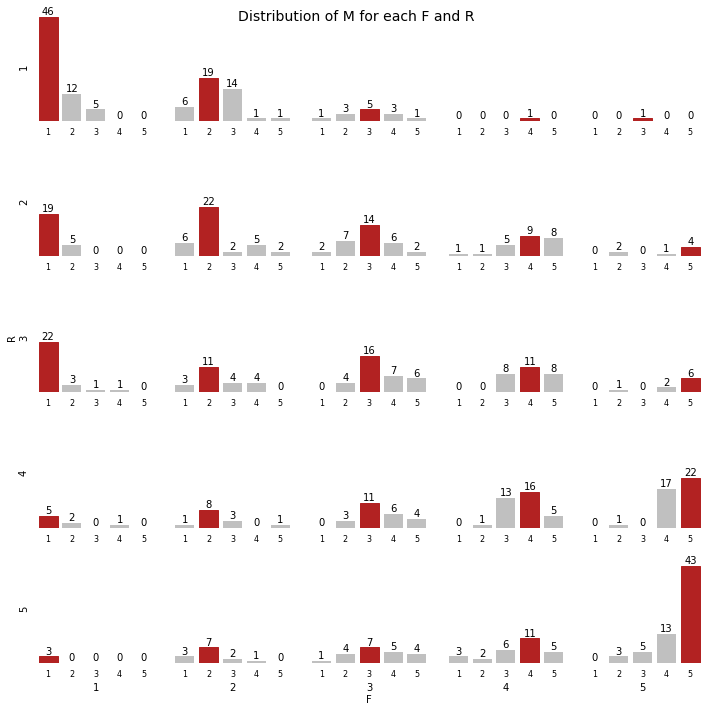

In [68]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = df_RFM[(df_RFM['R'] == r) & (df_RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

Как раз на это графике мы видим, как распределены клиенты по показателю выручки в осях частоты и даты последнего заказа. Так нижни правый угол - это наши чемпионы (F= 4 или 5). Так большинство клиентов (43+5) все таки попадают в самый высокий квинтиль по доходности.  

И наоборот, потерянные, верхний левый угол диаграммы, это клиенты, которые делали небольшое количество заказов и входили в нижние квинтили по доходности. 

Но можно и нужно переосмыслить сегментацию на основе мисии покупки клиента, стуктуры его корзины.

# Сегментация исходя из продуктовой корзины

В сегментации все больше за основу стараются брать миссию клиента. По сути, под покупательской миссией можно понимать истинную цель и причины, по которым покупатель делает тот или иной выбор. 

Изучим базовые предпочтения клиентов по сегментам.

## Интересы по сегментам

В данном случае, мы смотрим всю историю покупок клиента. Те клиент, делал покупки хотя бы один раз. Но можно брать и пенетрацию (проникновение) товара или товарной группы в счет. Петентрация в счет, например, лучше показывает значимость товара для клиента. Мы же пока говорим про общую структуру покупок клиента. 

In [69]:
voc_st={}
for s in segment:
    df_t=pd.pivot_table(df[df.Segment==s], values=['Level2'], index=['Name'], aggfunc={'Level2': list}).reset_index()
    df_t['Level2_2']=df_t['Level2'].apply(lambda x: list(set(x)))
    voc_t={}
    for i in df.Level2.unique():
        voc_t[i]=0
    for l in df.Level2.unique():
        for i, rows in df_t.iterrows():
            if l in rows['Level2_2']:
                voc_t[l]=voc_t[l]+1
    for i in df.Level2.unique():
        voc_t[i]=voc_t[i]/len(df_t)
    voc_st[s]=voc_t

In [70]:
data=pd.DataFrame(voc_st)
data[data==0]=np.nan

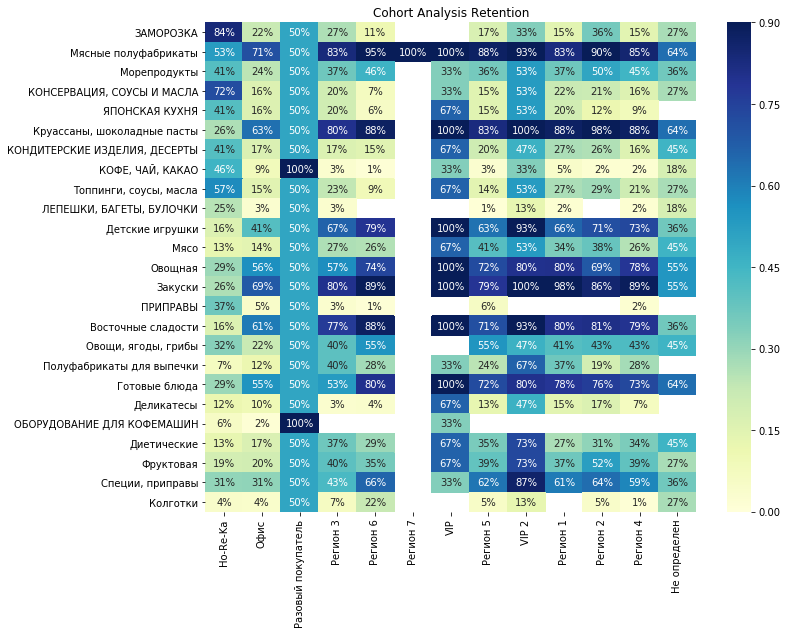

In [71]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis Retention')
sns.heatmap(data = data, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.9,
            cmap = "YlGnBu")
plt.show()

Мы видим, что интересы сегментов местами изолированы. Так "Ho-Re-Ka" - это "заморозка" и "консервация", те категории, которые слабо интересуют другие сегменты. "VIP" и "VIP2" - как раз наоборот нуждаются в широком наборе товаров. 

Товарные группы 'Мясные полуфабрикаты', 'Круассаны, шоколадные пасты', 'Закуски' - оптимально использовать для продвижения, так как эти группы интересны большинству сегментов. 

Но давайте вернемся к миссии. Для этого мы выполним кластеризацию в разрезе отдельных покупок и попробуем посомтреть, что является центром интересов. Ведь у одного и того же клиента в зависимости от ситуации можуг быть разные миссии покупок. 

## Сегментация на основе потребностей

Анализ проведем в разрезе гурпп товаров (Level 2).

In [72]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import rc
from sklearn.cluster import KMeans

In [73]:
df_level2=df.pivot_table(values=['Level2'], index='Invoice', aggfunc={'Level2': list})
df_level2['Level2']=df_level2.Level2.apply(lambda x: list(set(x)))
df_level2['Cnt']=df_level2.Level2.apply(lambda x: len(x))

In [74]:
print('Всего счетов: ', len(df_level2))
print('Счетов с более чем одной группой товаров: ', len(df_level2[df_level2['Cnt']>1]))

Всего счетов:  19664
Счетов с более чем одной группой товаров:  12203


Удалим счета, где меньше одной покупки, что результаты были более показательными. И подготовим данные для кластеризации.

In [75]:
df_level2=df_level2[df_level2['Cnt']>1]
print(len(df_level2))
df_level2.head()

12203


,Level2,Cnt
Invoice,,
00UT-000001,"[Топпинги, соусы, масла, КОФЕ, ЧАЙ, КАКАО]",2
00UT-000002,"[Фруктовая, Закуски, Круассаны, шоколадные пас...",7
00UT-000003,"[Закуски, Детские игрушки]",2
00UT-000005,"[Закуски, Круассаны, шоколадные пасты, Восточн...",6
00UT-000006,"[Готовые блюда, Закуски, Мясные полуфабрикаты]",3


In [76]:
a=df_level2.Level2
f=df.Level2.unique()
df_clust=pd.DataFrame([ [0 for k2 in range(len(f))] for k1 in range(len(a))], columns=list(f))
for i in range(len(a)):
    for k in a[i]:
        df_clust.loc[i][k]=1

In [77]:
df_clust.head()

,ЗАМОРОЗКА,Мясные полуфабрикаты,Морепродукты,"КОНСЕРВАЦИЯ, СОУСЫ И МАСЛА",ЯПОНСКАЯ КУХНЯ,"Круассаны, шоколадные пасты","КОНДИТЕРСКИЕ ИЗДЕЛИЯ, ДЕСЕРТЫ","КОФЕ, ЧАЙ, КАКАО","Топпинги, соусы, масла","ЛЕПЕШКИ, БАГЕТЫ, БУЛОЧКИ",...,Восточные сладости,"Овощи, ягоды, грибы",Полуфабрикаты для выпечки,Готовые блюда,Деликатесы,ОБОРУДОВАНИЕ ДЛЯ КОФЕМАШИН,Диетические,Фруктовая,"Специи, приправы",Колготки
0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Фактически мы получаем бинарную матрицу. Если в счете была товарная группа, в ячейке на пересечении 1. Иначе - 0.

In [78]:
data_for_clust=df_clust
from sklearn import preprocessing
dataNorm = preprocessing.normalize(data_for_clust)

In [79]:
data_dist = pdist(data_for_clust, 'euclidean')
data_linkage = linkage(data_dist, method='average')

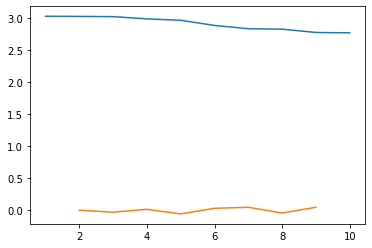

clusters: 9


In [80]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("clusters:", k)

"Метод локтя" рекомендует выполнять кластеризацию исходя из 9 кластеров. 

Выполним кластеризацию.

In [81]:
km_m = KMeans(n_clusters=9).fit(dataNorm)
df_clust['group_no']=km_m.labels_+1

Результаты можно представить в виде таблицы. Где на пересечении, какая часть счетов в данном кластере содержит ту или иную группу.

In [82]:
res1=df_clust.groupby('group_no').mean()
res1['Количество']=df_clust.groupby('group_no').size().values
res1.T

group_no,1,2,3,4,5,6,7,8,9
ЗАМОРОЗКА,0.11,0.03,0.03,0.03,0.67,0.03,0.02,0.05,0.02
Мясные полуфабрикаты,0.95,0.00,0.93,0.90,0.15,1.00,0.45,0.66,0.14
Морепродукты,0.06,0.05,0.06,0.07,0.09,0.07,0.03,0.11,0.04
"КОНСЕРВАЦИЯ, СОУСЫ И МАСЛА",0.05,0.03,0.02,0.03,0.61,0.02,0.03,0.04,0.02
ЯПОНСКАЯ КУХНЯ,0.03,0.04,0.02,0.04,0.29,0.05,0.04,0.07,0.04
"Круассаны, шоколадные пасты",0.00,0.54,1.00,0.13,0.04,0.56,0.60,0.00,0.83
"КОНДИТЕРСКИЕ ИЗДЕЛИЯ, ДЕСЕРТЫ",0.05,0.02,0.02,0.03,0.16,0.03,0.04,0.04,0.03
"КОФЕ, ЧАЙ, КАКАО",0.01,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.01
"Топпинги, соусы, масла",0.06,0.04,0.03,0.04,0.25,0.03,0.04,0.06,0.04
"ЛЕПЕШКИ, БАГЕТЫ, БУЛОЧКИ",0.02,0.01,0.01,0.01,0.14,0.01,0.01,0.01,0.01


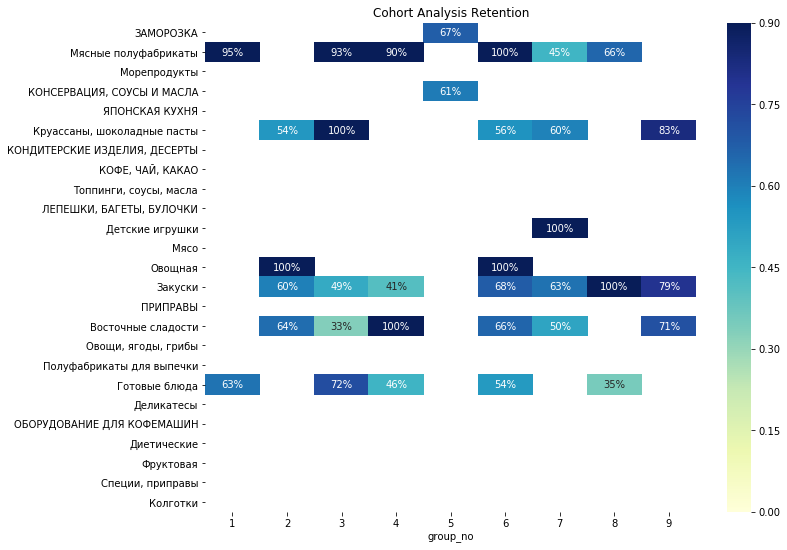

In [83]:
res2=res1.T
res2[res2<0.3]=np.nan

plt.figure(figsize = (11,9))
plt.title('Cohort Analysis Retention')
sns.heatmap(data = res2.loc[res2.index[:-1]], 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.9,
            cmap = "YlGnBu")
plt.show()

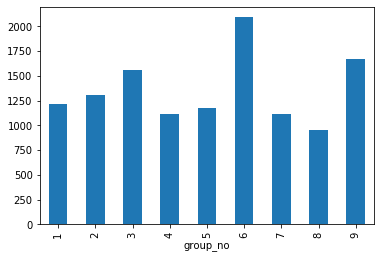

In [84]:
res1['Количество'].plot.bar()

Кластера по количеству счетов распределены относительно равномерно. Не наблюдается явных выбросов. 

Более наглядно в виде тепловой карты. Я думалил все значения меньше 0.3, чтобы картина была более наглядной. 

Так у нас есть явный сегмент "Заморозка и консервация, соусы, масла" (8), "Детские грушки(9).

Если отбросить слабые дефиринциаторы (берут многие кластера), то видим кластер с миссиями "Овощная" + "Готовые блюда" (2), "Сладости" (4) и тд. 

Давайте посмотрим на миссии в разрезе не счетов, а клиентов.

In [85]:
df_level2=df.pivot_table(values=['Level2'], index='Name', aggfunc={'Level2': list})
df_level2['Level2']=df_level2.Level2.apply(lambda x: list(set(x)))
df_level2['Cnt']=df_level2.Level2.apply(lambda x: len(x))
print(len(df_level2))
len(df_level2[df_level2['Cnt']>1])
print(len(df_level2))

608
608


Все клиенты брали больше одной товарной группы 2-го уровня. 

In [86]:
data_for_clust=df_clust
dataNorm = preprocessing.normalize(data_for_clust)

In [87]:
data_dist = pdist(data_for_clust, 'euclidean')
data_linkage = linkage(data_dist, method='average')

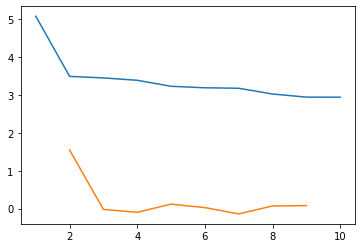

clusters: 2


In [88]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("clusters:", k)

"Метод локтя" указывает на два кластера, но я бы брал те же 9 кластеров. Отчасти, они будут схожи, так как большое количество клиентов имело небольшое количество заказов.

In [89]:
km_m = KMeans(n_clusters=9).fit(dataNorm)
df_clust['group_no']=km_m.labels_+1
df_clust.head()

,ЗАМОРОЗКА,Мясные полуфабрикаты,Морепродукты,"КОНСЕРВАЦИЯ, СОУСЫ И МАСЛА",ЯПОНСКАЯ КУХНЯ,"Круассаны, шоколадные пасты","КОНДИТЕРСКИЕ ИЗДЕЛИЯ, ДЕСЕРТЫ","КОФЕ, ЧАЙ, КАКАО","Топпинги, соусы, масла","ЛЕПЕШКИ, БАГЕТЫ, БУЛОЧКИ",...,"Овощи, ягоды, грибы",Полуфабрикаты для выпечки,Готовые блюда,Деликатесы,ОБОРУДОВАНИЕ ДЛЯ КОФЕМАШИН,Диетические,Фруктовая,"Специи, приправы",Колготки,group_no
0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,9
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [90]:
res1=df_clust.groupby('group_no').mean()
res1['Количество']=df_clust.groupby('group_no').size().values
res1

,ЗАМОРОЗКА,Мясные полуфабрикаты,Морепродукты,"КОНСЕРВАЦИЯ, СОУСЫ И МАСЛА",ЯПОНСКАЯ КУХНЯ,"Круассаны, шоколадные пасты","КОНДИТЕРСКИЕ ИЗДЕЛИЯ, ДЕСЕРТЫ","КОФЕ, ЧАЙ, КАКАО","Топпинги, соусы, масла","ЛЕПЕШКИ, БАГЕТЫ, БУЛОЧКИ",...,"Овощи, ягоды, грибы",Полуфабрикаты для выпечки,Готовые блюда,Деликатесы,ОБОРУДОВАНИЕ ДЛЯ КОФЕМАШИН,Диетические,Фруктовая,"Специи, приправы",Колготки,Количество
group_no,,,,,,,,,,,,,,,,,,,,,
1,0.02,0.32,0.06,0.02,0.05,0.51,0.05,0.02,0.06,0.02,...,0.04,0.02,0.11,0.01,0.00,0.06,0.06,0.09,0.00,3857
2,0.07,0.83,0.10,0.02,0.01,0.00,0.02,0.01,0.02,0.00,...,1.00,0.03,0.76,0.01,0.00,0.05,0.06,0.14,0.00,182
3,0.03,0.96,0.07,0.03,0.03,0.22,0.03,0.00,0.04,0.01,...,0.10,0.01,0.53,0.01,0.00,0.05,0.10,0.09,0.01,1164
4,0.77,0.17,0.08,0.70,0.31,0.05,0.13,0.08,0.22,0.14,...,0.04,0.00,0.04,0.01,0.00,0.01,0.03,0.04,0.00,1031
5,0.21,1.00,0.07,0.10,0.08,0.00,0.10,0.02,0.12,0.05,...,0.00,0.02,0.00,0.03,0.00,0.05,0.05,0.09,0.01,407
6,0.05,0.95,0.05,0.03,0.01,0.00,0.03,0.01,0.03,0.01,...,0.00,0.01,1.00,0.00,0.00,0.03,0.04,0.07,0.00,631
7,0.03,0.93,0.06,0.02,0.02,1.00,0.02,0.00,0.02,0.01,...,0.12,0.02,0.72,0.01,0.00,0.04,0.04,0.10,0.00,1543
8,0.03,0.00,0.05,0.03,0.04,0.59,0.02,0.00,0.04,0.01,...,0.06,0.02,0.15,0.01,0.00,0.06,0.14,0.14,0.00,1198
9,0.03,0.96,0.07,0.02,0.05,0.53,0.03,0.00,0.03,0.01,...,0.11,0.03,0.53,0.01,0.00,0.07,0.16,0.16,0.00,2190


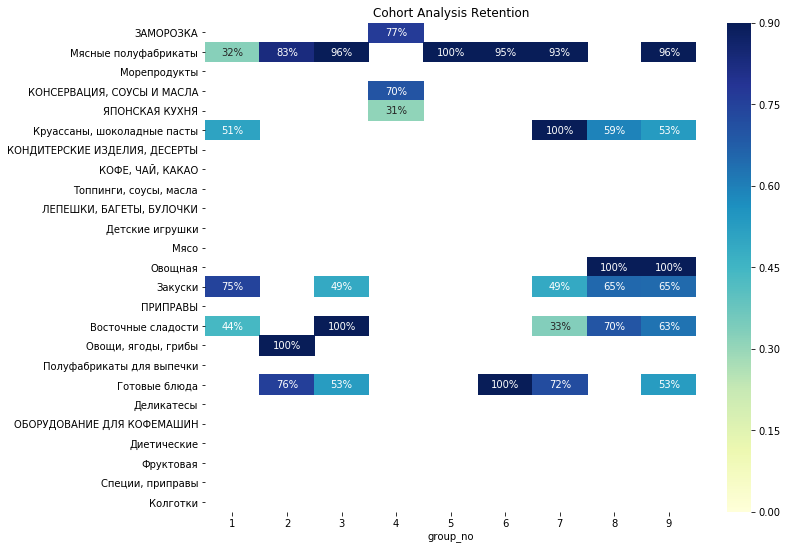

In [91]:
res2=res1.T
res2[res2<0.3]=np.nan

plt.figure(figsize = (11,9))
plt.title('Cohort Analysis Retention')
sns.heatmap(data = res2.loc[res2.index[:-1]], 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.9,
            cmap = "YlGnBu")
plt.show()

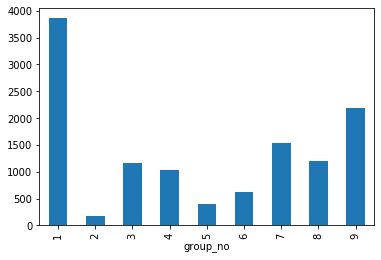

In [92]:
res1['Количество'].plot.bar()

Как и ожидалось, мы получили достаточно похожие сегменты. Но можно говорить о выбросах, так кластеры 1 и 2 относительно малочислены. Их стоит изучить более внимательно. 

Если продолжать данную сегментацию, то нам стоит ее совместить в будущем с прибыльностью и коэффициентами удержания. Так как фактически мы говорим о изолированных товарных предпочтениях. Это позволит как выделить наиболее привлекательные сегменты, так и принять обоснованное решение об оптимизации товарной матрицы. 

Если продолжать анализ покупательских предпочтений, то нельзя обойти стороной потенциал допродаж. И здесь нам помогжет выработать статистически обоснованные решения метод "Ассоциативные правила".

# Ассоциативные правила

*Подробнее, например, https://habr.com/ru/company/ods/blog/353502/*

Впервые задача поиска ассоциативных правил была предложена для нахождения типичных шаблонов покупок, совершаемых в супермаркетах, поэтому иногда ее еще называют анализом рыночной корзины (market basket analysis). Целью анализа является установление следующих зависимостей: если в транзакции встретился некоторый набор элементов XX, то на основании этого можно сделать вывод о том, что другой набор элементов YY также же должен появиться в этой транзакции. Установление таких зависимостей дает нам возможность находить очень простые и интуитивно понятные правила.

Рассмотрим на примере. 

In [93]:
# загрузим пакеты, необходимые для выполнения анализа
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [94]:
# подготовим данные
df_level2=df.pivot_table(values=['Level2'], index='Invoice', aggfunc={'Level2': list})
df_level2['Level2']=df_level2.Level2.apply(lambda x: list(set(x)))
df_level2['Cnt']=df_level2.Level2.apply(lambda x: len(x))
df_level2=df_level2[df_level2['Cnt']>1]
df_level2.head()

,Level2,Cnt
Invoice,,
00UT-000001,"[Топпинги, соусы, масла, КОФЕ, ЧАЙ, КАКАО]",2
00UT-000002,"[Фруктовая, Закуски, Круассаны, шоколадные пас...",7
00UT-000003,"[Закуски, Детские игрушки]",2
00UT-000005,"[Закуски, Круассаны, шоколадные пасты, Восточн...",6
00UT-000006,"[Готовые блюда, Закуски, Мясные полуфабрикаты]",3


In [95]:
te = TransactionEncoder()
te_ary = te.fit(df_level2.Level2.values).transform(df_level2.Level2.values)
df_as = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_as, min_support=0.05, use_colnames=True)

In [96]:
rules_brand=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules_brand

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Детские игрушки),(Восточные сладости),0.18,0.46,0.10,0.58,1.24,0.02,1.27
1,(Восточные сладости),(Закуски),0.46,0.53,0.30,0.64,1.20,0.05,1.30
2,(Закуски),(Восточные сладости),0.53,0.46,0.30,0.56,1.20,0.05,1.21
3,(Восточные сладости),"(Круассаны, шоколадные пасты)",0.46,0.47,0.27,0.58,1.25,0.05,1.28
4,"(Круассаны, шоколадные пасты)",(Восточные сладости),0.47,0.46,0.27,0.58,1.25,0.05,1.28
...,...,...,...,...,...,...,...,...,...
153,"(Мясные полуфабрикаты, Закуски, Круассаны, шок...",(Восточные сладости),0.07,0.46,0.05,0.77,1.66,0.02,2.32
154,"(Восточные сладости, Закуски, Мясные полуфабри...","(Круассаны, шоколадные пасты)",0.08,0.47,0.05,0.63,1.36,0.01,1.45
155,"(Восточные сладости, Мясные полуфабрикаты, Кру...",(Закуски),0.07,0.53,0.05,0.78,1.46,0.02,2.10
156,"(Закуски, Круассаны, шоколадные пасты, Овощная)","(Восточные сладости, Мясные полуфабрикаты)",0.10,0.28,0.05,0.51,1.82,0.02,1.46


Мы получили 158 патернов покупок. Например, если клиент "забросил" в корзину набор (Овощная, Круассаны, шоколадные пасты, Закуски), то с вероятностью 0,51 (confidence) он приобретет еще и (Восточные сладости, Мясные полуфабрикаты). Вариантов таких покупок в общей выборке было 5% (support). Кстати, обратное неверно. Те клиент, который купит (Восточные сладости, Мясные полуфабрикаты), скорее всего не будет брать остальной набор. Ну или пример попроще, тем кто покупает восточные сладости продавать еще и закуску. Потенциал увеличение около 30%. Часто клиентам просто надо предлоить. Исходя из этой информации можно формировать и систему рекомендаций, например, на сайте.

До сих пор мы использовали технологии Data Mining. Пришла пора опробовать Machine Learning. Например, замутить быстро на коленке систему скоринга клиентов. 

# Скоринг клиентов

Попробуем решить интересную практическую задачу: оценить по первому заказу вероятность того, что этот клиент будет работать с намит больше года. 

Подготовим данные.

In [97]:
df_invoice=df_invoice.sort_values(by=['Date'],  ascending=True).reset_index()

In [98]:
df_name=df_invoice.groupby('Name').first().reset_index()
df_t=df_invoice.groupby('Name').nth(-1)['Date'].reset_index()
df_t.columns=['Name', 'last_date']
df_name=df_name.merge(df_t, on='Name')
df_name['Delta']=(df_name['last_date']-df_name['Date'])
df_name['Delta']=df_name['Delta'].apply(lambda x: x.days)

df_name.sample(5)

,Name,index,Invoice,Date,Profit,Qnty,Revenue,Segment,InvoiceYear,StartYear,last_date,Delta
242,зинаида,16916,00UT-003466,2017-03-27,"3,238.99",101.00,"7,256.00",Регион 5,2017,2017,2017-03-27,0
534,танюша,9341,Фр00-003452,2015-11-12,"2,652.96",77.47,"6,913.61",Регион 6,2015,2015,2017-12-01,750
299,лаврента,4945,Фр00-000344,2016-01-14,"1,074.75",84.00,"2,961.10",Регион 4,2016,2015,2017-11-01,657
330,линуша,19496,Фр00-005317,2016-04-27,"1,440.00",30.00,"2,670.00",Регион 3,2016,2016,2016-10-05,161
112,венуша,1200,Фр00-000315,2015-06-10,"1,518.07",50.00,"4,136.00",Регион 2,2015,2015,2017-10-01,844


В этой таблице мы собрали базовую информацию о клиентах. 
* 'Date' - дата первой покупки. 
* 'last_date' - дата последней покупки. 
* 'Delta' - разница в днях между последней и первой датой. 

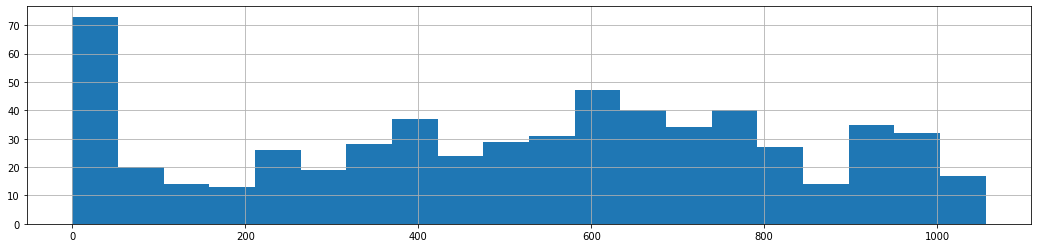

In [99]:
df_name.Delta.hist(figsize=(18,4), bins=20);

In [100]:
df_name.Delta.describe()

count     600.00
mean      516.23
std       309.12
min         0.00
25%       287.00
50%       546.50
75%       754.00
max     1,056.00
Name: Delta, dtype: float64

Мы видим, что 50% клиентов сотрудничали с нами больше 409 дней. Но для прогнозирования возьмем период год. Те нас будет интересовать вопрос, будет ли этот клиент сотрудничать с нами больше одного года или нет.

Для того, чтобы дать ответ на этот вопрос, расширим набор полей нашей таблицы.

In [101]:
df_t2=df.groupby('Invoice')['SKU'].apply(list)[df_name.Invoice].reset_index()
df_name=df_name.merge(df_t2, on='Invoice')

In [102]:
df_name['SKU']=df_name.SKU.apply(lambda x: list(set(x)))
df_name['Cnt']=df_name.SKU.apply(lambda x: len(x))

print(len(df_name))
df_name=df_name[df_name.StartYear<2017]
print(len(df_name))

df_name['Y']=df_name.Delta.apply(lambda x: 1 if x>365 else 0)
df_name['Segment_f']=pd.factorize(df_name['Segment'])[0]

df_name.sample(5)

600
559


,Name,index,Invoice,Date,Profit,Qnty,Revenue,Segment,InvoiceYear,StartYear,last_date,Delta,SKU,Cnt,Y,Segment_f
329,линка,11177,Фр00-000110,2015-01-10,"5,232.50",70.00,"10,412.50",Офис,2015,2015,2017-12-01,1056,"[Сосиски Обнинские 1/5 Молочные вес Россия, Са...",2,1,0
433,нинаня,10997,Фр00-017967,2016-12-27,"15,324.85",63.06,"41,938.74",Ho-Re-Ka,2016,2016,2017-09-03,250,"[Говядина вырезка 1,4-1,8кг Tenderloin с/м Бра...",13,0,4
415,натоха,4681,Фр00-002985,2015-02-12,"2,100.64",58.00,"4,353.00",Регион 1,2015,2015,2017-11-01,993,"[Сухарики ржаные ""Клинские снеки"" по-венгерск...",17,1,6
573,шура,16230,Фр00-014918,2016-02-11,"3,348.26",96.00,"8,789.00",Регион 5,2016,2016,2017-11-01,629,"[Сухарики ржаные ""Клины"" со вкусом сыра 40г*80...",41,1,3
582,эмилианка,14077,Фр00-002553,2015-11-23,"5,059.02",191.27,"13,643.60",Регион 4,2015,2015,2017-09-01,648,"[Сухарики ржаные ""Клины"" со вкусом сыра 40г*80...",51,1,2


'Cnt' - это количество наименований, которые были в первом заказе. А 'Segment_f'- это закодированный числами сегмент. 'Y' равен нулю если клиент работал с нами меньше 365 дней и 1 если больше. Фактически это целевая величина, которую будем предсказывать. 

Для обучения модели будем будем использовать четыре параметра:
* сумма первого счета
* количество единиц товара 
* количество наименований товара
* сегмент

In [103]:
df_name.columns

Index(['Name', 'index', 'Invoice', 'Date', 'Profit', 'Qnty', 'Revenue',
       'Segment', 'InvoiceYear', 'StartYear', 'last_date', 'Delta', 'SKU',
       'Cnt', 'Y', 'Segment_f'],
      dtype='object')

In [104]:
col=['Revenue', 'Qnty', 'Segment_f', 'Cnt']

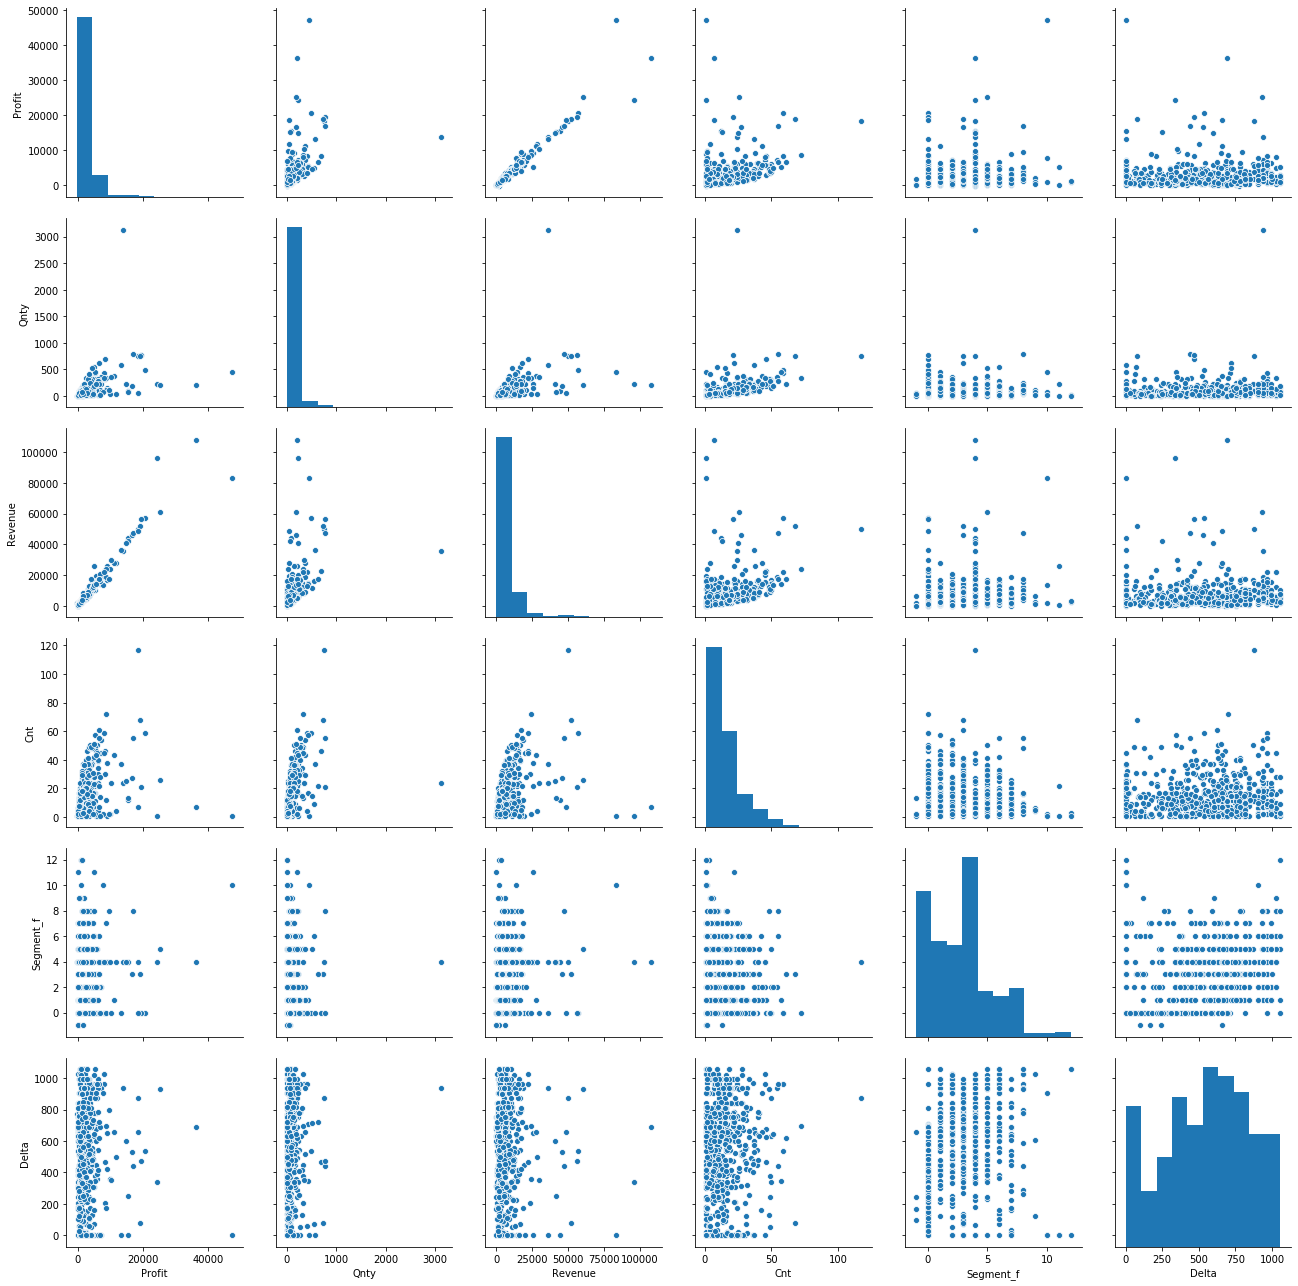

In [105]:
sns.pairplot(df_name[['Profit', 'Qnty', 'Revenue', 'Cnt', 'Segment_f', 'Delta']],height=3);

За счет выбросов на всегда очевидна зависимость между сроком сотрудничества и другими параметрами. Возможно, алгоритм машинного обучения RandomForest сможет выявить и учесть взаимосвязи.

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

In [124]:
model = RandomForestClassifier(n_estimators=10)
model.fit(df_name[col], df_name.Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.3094, 'Revenue'], [0.2763, 'Qnty'], [0.2311, 'Segment_f'], [0.1831, 'Cnt']]

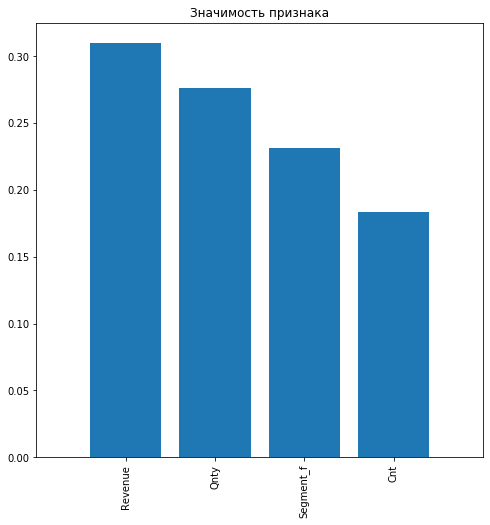

In [126]:
#удобнее отобразить на столбчатой диаграмме
d_first = len(col)
plt.figure(figsize=(8, 8))
plt.title("Значимость признака")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(col)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [127]:
r2_score(model.predict(df_name[col]), df_name.Y)

0.8901947945653953

Мы получили модель с R2=0.89, что очень неплохо. Про точность поговрим чуть позже. Пока, хочу проилюстрровать умение RandomForest показывать значимость признаков на принятие моделью решения. Оказалось, что одинаковую роль играет сумма и количество единиц товара. Далее принадлежность к сегменту и на третьем месте количество наименований товара. Те нам интереснее привлекать клиентов кто берет много одного наименования. Допродажи не сильно будут влиять на продолжительность сотрудничества.

Или можно выдвинуть гипотезу, что постоянные клиенты очень чувствительны к конкурентоспособности предложения и склонны работать с несколькими поставщиками. 


Что касается точность нашей модели. 

In [128]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [129]:
conf_mat = confusion_matrix(df_name.Y, model.predict(df_name[col]))
print(conf_mat)

[[144   7]
 [  5 403]]


In [130]:
print(classification_report(df_name.Y, model.predict(df_name[col])))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       151
           1       0.98      0.99      0.99       408

    accuracy                           0.98       559
   macro avg       0.97      0.97      0.97       559
weighted avg       0.98      0.98      0.98       559



Если отбросить эффект переобучения (мы не формировали обучающую и тестовую выборку), то результат вполне интересный. Точность модели (accuracy) 98%. Модель 7 раз из 151 ошиблась, указав что клиент будет работать с нами больше года. И 5 раз из 408 неправильно классифицировала клиентов, которые сотрудничали больше года.

Даже если точность омдели упадет на тестовой выборке до 65-70%, она может быть очень полезна для скоринга клиентов на входе. 

# Выводы

В данном блокноте представлен достаточно полный и комплексный анализ клиентской базы. Методология может быть применена с небольшими уточнениями и дополнениями как к b2b, так и b2c компаниям. 

Выводы позволяют принимать решения как в части приоритета по клиентам, так и по ассортименту. Собранная информация может быть основной для применения более сложных и результативных подходов с применением машинного обучения. 